In [1]:
import os
import sys

#sys.path.insert(0,'/h1/jmelvin/.local/lib/python2.7/site-packages')

#import tecplot as tec
import netCDF4 as nc
import pandas as pd
import numpy as np
#import scipy.integrate
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [2]:
def NaluForcing(fname):
  dfS = pd.read_table(fname, delimiter='\[|,|\]\[|\]', engine='python', header=None, names=['trash1','x1','x2','x3','x4','y1','y2','y3','y4','z1','z2','z3','z4','forceX1','forceX2','forceX3','forceX4','forceY1','forceY2','forceY3','forceY4','forceZ1','forceZ2','forceZ3','forceZ4','norm1','norm2','norm3','norm4','alpha1','alpha2','alpha3','alpha4','v21','v22','v23','v24','tke1','tke2','tke3','tke4','tdr1','tdr2','tdr3','tdr4','rk1','rk2','rk3','rk4','ux1','ux2','ux3','ux4','uy1','uy2','uy3','uy4','uz1','uz2','uz3','uz4','trash2'])
    
  del dfS['trash1']
  del dfS['trash2']

  tsRows = (dfS.loc[(dfS['x1'] == dfS['x1'].values[0]) & (dfS['z1'] == dfS['z1'].values[0]) & (dfS['y1'] == dfS['y1'].values[0])]).index[1]
  print tsRows

  searching = True
  check = tsRows
  while (searching):
    tsRowsTmp = (dfS.loc[(dfS['x1'] == dfS['x1'].values[check]) & (dfS['z1'] == dfS['z1'].values[check]) & (dfS['y1'] == dfS['y1'].values[check])]).index[0]
    if (tsRowsTmp == check):
        tsRows = check
        searching = False
    check = check - 1
    
  print tsRows

  dfS['timestep'] = dfS.index/tsRows

  tmp1 = dfS.loc[:,['x1','y1','z1','forceX1','forceY1','forceZ1','norm1','alpha1','v21','tke1','tdr1','rk1','ux1','uy1','uz1','timestep']]
  tmp2 = dfS.loc[:,['x2','y2','z2','forceX2','forceY2','forceZ2','norm2','alpha2','v22','tke2','tdr2','rk2','ux2','uy2','uz2','timestep']]
  tmp3 = dfS.loc[:,['x3','y3','z3','forceX3','forceY3','forceZ3','norm3','alpha3','v23','tke3','tdr3','rk3','ux3','uy3','uz3','timestep']]
  tmp4 = dfS.loc[:,['x4','y4','z4','forceX4','forceY4','forceZ4','norm4','alpha4','v24','tke4','tdr4','rk4','ux4','uy4','uz4','timestep']]
  tmp1.columns = ['x','y','z','forceX','forceY','forceZ','norm','alpha','v2','tke','tdr','rk','ux','uy','uz','timestep']
  tmp2.columns = ['x','y','z','forceX','forceY','forceZ','norm','alpha','v2','tke','tdr','rk','ux','uy','uz','timestep']
  tmp3.columns = ['x','y','z','forceX','forceY','forceZ','norm','alpha','v2','tke','tdr','rk','ux','uy','uz','timestep']
  tmp4.columns = ['x','y','z','forceX','forceY','forceZ','norm','alpha','v2','tke','tdr','rk','ux','uy','uz','timestep']
  dfS = pd.concat([tmp1,tmp2,tmp3,tmp4])

  dfS["fxfx"] = dfS["forceX"]*dfS["forceX"]
  dfS["fyfy"] = dfS["forceY"]*dfS["forceY"]
  dfS["fzfz"] = dfS["forceZ"]*dfS["forceZ"]

  return dfS

def NaluForcingPlot(df,var,ts,plotHere,save,xL,xH,yL,yH,customAxes):
  zCoords = df.z.unique()
  yCoords = df.y.unique()
  xCoords = df.x.unique()
  timesteps = df.timestep.unique()

  planarAvgForce = np.zeros((len(yCoords),16))
  index = 0
  for yc in yCoords:
  #for yc in xCoords:
      sliceY = df.loc[(df['y'] == yc) & (df['timestep'] == ts)]
      #sliceY = df.loc[(df['x'] == yc) & (df['y'] > 0.49) & (df['y'] < 0.51) & (df['timestep'] == ts)]
      avgFx = sliceY.forceX.sum()/len(sliceY)
      avgFy = sliceY.forceY.sum()/len(sliceY)
      avgFz = sliceY.forceZ.sum()/len(sliceY)
      varFx = sliceY.fxfx.sum()/len(sliceY)
      varFy = sliceY.fyfy.sum()/len(sliceY)
      varFz = sliceY.fzfz.sum()/len(sliceY)
      norm = sliceY.norm.sum()/len(sliceY)
      v2 = sliceY.v2.sum()/len(sliceY)
      alpha = sliceY.alpha.sum()/len(sliceY)
      tke = sliceY.tke.sum()/len(sliceY)
      tdr = sliceY.tdr.sum()/len(sliceY)
      rk = sliceY.rk.sum()/len(sliceY)
      ux = sliceY.ux.sum()/len(sliceY)
      uy = sliceY.uy.sum()/len(sliceY)
      uz = sliceY.uz.sum()/len(sliceY)
      planarAvgForce[index] = np.array([yc,avgFx,avgFy,avgFz,varFx,varFy,varFz,norm,v2,alpha,tke,tdr,rk,ux,uy,uz])
      index = index + 1
  pltFrame = pd.DataFrame(planarAvgForce,columns=['y','Fx','Fy','Fz','fxfx','fyfy','fzfz','norm','v2','alpha','tke','tdr','rk','ux','uy','uz'])
  pltFrame = pltFrame.sort_values(by=['y'])

  if (plotHere):
      fig, ax = plt.subplots()
      ax.plot(pltFrame.y,pltFrame[var])
      ax.set(xlabel='y',ylabel="%s" % var,title="Planar average %s - timestep %i" % (var,ts))

      if (save):
          plt.savefig('/workspace/jmelvin/Research/channelFlow/alphaMovies/nalu_' + str(ts).zfill(4))
          plt.close(fig)
      else:
          if (customAxes):
            ax.set_xlim(xL,xH)
            ax.set_ylim(yL,yH)
          plt.show()
        
  return pltFrame

def CDPForcing(basename,numProcs):
  for i in range(0,numProcs):
      fname = basename + str(i).zfill(3) + ".txt"
      #tmp = pd.read_table(fname,delim_whitespace=True,header=None,names=['x','y','z','forceX','forceY','forceZ','norm','v2','alpha','tke','tdr','rk','ux','uy','uz'])
      tmp = pd.read_table(fname,delim_whitespace=True,header=None,names=['x','y','z','forceX','forceY','forceZ','norm','alpha','v2','tke','tdr','rk','ux','uy','uz'])
      tsRows = (tmp.loc[(tmp['x'] == tmp['x'].values[0]) & (tmp['z'] == tmp['z'].values[0]) & (tmp['y'] == tmp['y'].values[0])]).index[1]
      tmp['timestep'] = tmp.index/tsRows
      if (i == 0):
          dfS = tmp
      else:
          dfS = pd.concat([dfS,tmp])

  dfS['fxfx'] = dfS['forceX']*dfS['forceX']
  dfS['fyfy'] = dfS['forceY']*dfS['forceY']
  dfS['fzfz'] = dfS['forceZ']*dfS['forceZ']
  
  return dfS

def CDPForcingPlot(df,var,ts,plotHere,save):
  zCoords = df.z.unique()
  yCoords = df.y.unique()
  xCoords = df.x.unique()
  timesteps = df.timestep.unique()

  planarAvgForce = np.zeros((len(yCoords),16))
  index = 0
  for yc in yCoords:
  #for yc in xCoords:
      sliceY = df.loc[(df['y'] == yc) & (df['timestep'] == ts)]
      #sliceY = df.loc[(df['x'] == yc) & (df['y'] > 0.49) & (df['y'] < 0.51) & (df['timestep'] == ts)]
      avgFx = sliceY.forceX.sum()/len(sliceY)
      avgFy = sliceY.forceY.sum()/len(sliceY)
      avgFz = sliceY.forceZ.sum()/len(sliceY)
      varFx = sliceY.fxfx.sum()/len(sliceY)
      varFy = sliceY.fyfy.sum()/len(sliceY)
      varFz = sliceY.fzfz.sum()/len(sliceY)
      norm = sliceY.norm.sum()/len(sliceY)
      v2 = sliceY.v2.sum()/len(sliceY)
      alpha = sliceY.alpha.sum()/len(sliceY)
      tke = sliceY.tke.sum()/len(sliceY)
      tdr = sliceY.tdr.sum()/len(sliceY)
      rk = sliceY.rk.sum()/len(sliceY)
      ux = sliceY.ux.sum()/len(sliceY)
      uy = sliceY.uy.sum()/len(sliceY)
      uz = sliceY.uz.sum()/len(sliceY)
      planarAvgForce[index] = np.array([yc,avgFx,avgFy,avgFz,varFx,varFy,varFz,norm,v2,alpha,tke,tdr,rk,ux,uy,uz])
      index = index + 1
  pltFrame = pd.DataFrame(planarAvgForce,columns=['y','Fx','Fy','Fz','fxfx','fyfy','fzfz','norm','v2','alpha','tke','tdr','rk','ux','uy','uz'])
  pltFrame = pltFrame.sort_values(by=['y'])
    
  if (plotHere):
      fig, ax = plt.subplots()
      ax.plot(pltFrame.y,pltFrame[var])
      ax.set(xlabel='y',ylabel="%s" % var,title="Planar average %s - timestep %i" % (var,ts))

      plt.show()

  else:
      return pltFrame


def plotCDPvsNalu(dfCDP,dfNalu,var,ts,save,xL,xH,yL,yH,customAxes,NaluSkip):
  cdpPlot = CDPForcingPlot(dfCDP,var,ts,False,False)
  naluPlot = NaluForcingPlot(dfNalu,var,ts*NaluSkip,False,False,0,0,0,0,False)
  if (var != "forcing"):
      fig, ax = plt.subplots()
      ax.plot(cdpPlot.y,cdpPlot[var],'b')
      ax.plot(naluPlot.y,naluPlot[var],'r')
      ax.set(xlabel='y',ylabel="%s" % var,title="Planar average %s - timestep %i" % (var,ts))
      if (customAxes):
        ax.set_xlim(xL,xH)
        ax.set_ylim(yL,yH)
  else:
      fig = plt.figure()
      ax1 = plt.subplot(311)
      ax1.plot(cdpPlot.y,cdpPlot['fxfx'],'b')
      ax1.plot(naluPlot.y,naluPlot['fxfx'],'r')
      ax1.set(xlabel='y',ylabel="%s" % 'fxfx',title="Planar average %s - timestep %i" % ('fxfx',ts)) 
      ax2 = plt.subplot(312)
      ax2.plot(cdpPlot.y,cdpPlot['fyfy'],'b')
      ax2.plot(naluPlot.y,naluPlot['fyfy'],'r')
      ax2.set(xlabel='y',ylabel="%s" % 'fyfy',title="Planar average %s - timestep %i" % ('fyfy',ts)) 
      ax3 = plt.subplot(313)
      ax3.plot(cdpPlot.y,cdpPlot['fzfz'],'b')
      ax3.plot(naluPlot.y,naluPlot['fzfz'],'r')
      ax3.set(xlabel='y',ylabel="%s" % 'fzfz',title="Planar average %s - timestep %i" % ('fzfz',ts)) 

  if (save):
      plt.tight_layout()
      plt.savefig('/workspace/jmelvin/Research/dataAnalysis/CDPvsNalu_' + var + "_" + str(ts).zfill(4))
      plt.close(fig)
  else:
      print "CDP - blue, Nalu - red"
      plt.show()
    
def plotNaluvsNalu(dfNalu1,dfNalu2,var,ts,save,xL,xH,yL,yH,customAxes,NaluSkip):
  naluPlot1 = NaluForcingPlot(dfNalu1,var,ts*NaluSkip,False,False,0,0,0,0,False)
  naluPlot2 = NaluForcingPlot(dfNalu2,var,ts*NaluSkip,False,False,0,0,0,0,False)
  if (var != "forcing"):
      fig, ax = plt.subplots()
      ax.plot(naluPlot1.y,naluPlot1[var],'b')
      ax.plot(naluPlot2.y,naluPlot2[var],'r')
      ax.set(xlabel='y',ylabel="%s" % var,title="Planar average %s - timestep %i" % (var,ts))
      if (customAxes):
        ax.set_xlim(xL,xH)
        ax.set_ylim(yL,yH)
  else:
      fig = plt.figure()
      ax1 = plt.subplot(311)
      ax1.plot(naluPlot1.y,naluPlot1['fxfx'],'b')
      ax1.plot(naluPlot2.y,naluPlot2['fxfx'],'r')
      ax1.set(xlabel='y',ylabel="%s" % 'fxfx',title="Planar average %s - timestep %i" % ('fxfx',ts)) 
      ax2 = plt.subplot(312)
      ax2.plot(naluPlot2.y,naluPlot2['fyfy'],'b')
      ax2.plot(naluPlot1.y,naluPlot1['fyfy'],'r')
      ax2.set(xlabel='y',ylabel="%s" % 'fyfy',title="Planar average %s - timestep %i" % ('fyfy',ts)) 
      ax3 = plt.subplot(313)
      ax3.plot(naluPlot1.y,naluPlot1['fzfz'],'b')
      ax3.plot(naluPlot2.y,naluPlot2['fzfz'],'r')
      ax3.set(xlabel='y',ylabel="%s" % 'fzfz',title="Planar average %s - timestep %i" % ('fzfz',ts)) 

  if (save):
      plt.tight_layout()
      plt.savefig('/workspace/jmelvin/Research/dataAnalysis/CDPvsNalu_' + var + "_" + str(ts).zfill(4))
      plt.close(fig)
  else:
      print "CDP - blue, Nalu - red"
      plt.show()
    
def plotNaluTSs(dfNalu,var,ts,save,ts2):
  naluPlot1 = NaluForcingPlot(dfNalu,var,ts,False,False,0,0,0,0,False)
  naluPlot2 = NaluForcingPlot(dfNalu,var,ts2,False,False,0,0,0,0,False)
  if (var != "forcing"):
      fig, ax = plt.subplots()
      ax.plot(naluPlot1.y,naluPlot1[var],'b')
      ax.plot(naluPlot2.y,naluPlot2[var],'r')
      ax.set(xlabel='y',ylabel="%s" % var,title="Planar average %s - timestep %i" % (var,ts))
  else:
      fig = plt.figure()
      ax1 = plt.subplot(311)
      ax1.plot(naluPlot1.y,naluPlot1['fxfx'],'b')
      ax1.plot(naluPlot2.y,naluPlot2['fxfx'],'r')
      ax1.set(xlabel='y',ylabel="%s" % 'fxfx',title="Planar average %s - timestep %i" % ('fxfx',ts)) 
      ax2 = plt.subplot(312)
      ax2.plot(naluPlot2.y,naluPlot2['fyfy'],'b')
      ax2.plot(naluPlot1.y,naluPlot1['fyfy'],'r')
      ax2.set(xlabel='y',ylabel="%s" % 'fyfy',title="Planar average %s - timestep %i" % ('fyfy',ts)) 
      ax3 = plt.subplot(313)
      ax3.plot(naluPlot1.y,naluPlot1['fzfz'],'b')
      ax3.plot(naluPlot2.y,naluPlot2['fzfz'],'r')
      ax3.set(xlabel='y',ylabel="%s" % 'fzfz',title="Planar average %s - timestep %i" % ('fzfz',ts)) 

  if (save):
      plt.tight_layout()
      plt.savefig('/workspace/jmelvin/Research/dataAnalysis/CDPvsNalu_' + var + "_" + str(ts).zfill(4))
      plt.close(fig)
  else:
      print "CDP - blue, Nalu - red"
      plt.show()
      
  

SyntaxError: Missing parentheses in call to 'print'. Did you mean print(tsRows)? (<ipython-input-2-383763f16003>, line 8)

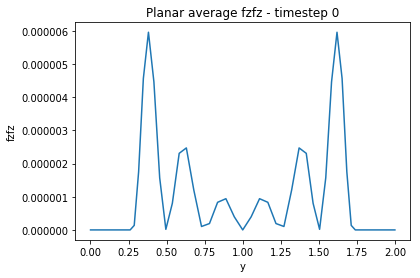

In [88]:
cdpForceDF = CDPForcing("/workspace/jmelvin/Research/dataFiles/CDP-Best_70119/force",96)
CDPForcingPlot(cdpForceDF,"fzfz",0,True,False)

In [86]:
NaluForceDF = NaluForcing("/workspace/jmelvin/Research/dataFiles/Nalu-Best_70119/forcingField.txt")

27074
27071


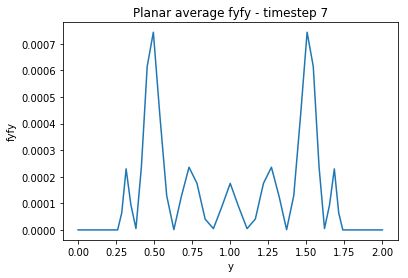

In [97]:
CDPForcingPlot(cdpForceDF,"fyfy",7,True,False)

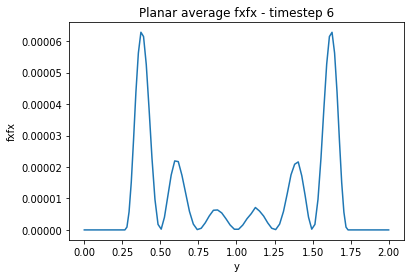

,y,Fx,Fy,Fz,fxfx,fyfy,fzfz,norm,v2,alpha,tke,tdr,rk,ux,uy,uz
0,0.000250,0,0,0,0,0,0,0,0.999977,0.758102,3.454412e-12,0.404941,1.973860,0.384168,1.000000,0.384168
11,0.000750,0,0,0,0,0,0,0,0.999932,1.314315,1.353529e-10,0.980297,3.921572,0.753194,1.000000,0.753194
24,0.001279,0,0,0,0,0,0,0,0.999917,3.086689,6.035147e-11,1.393560,5.729132,0.883952,0.895225,0.883952
29,0.001836,0,0,0,0,0,0,0,0.999932,7.051258,-3.073175e-09,1.719660,7.396540,0.937822,0.600510,0.937822
34,0.002426,0,0,0,0,0,0,0,0.999953,13.698197,-3.857568e-09,1.983060,8.898638,0.962811,0.432001,0.962811
36,0.003048,0,0,0,0,0,0,0,0.999979,22.663501,-8.492463e-09,2.199290,10.235400,0.975709,0.331128,0.975709
46,0.003705,0,0,0,0,0,0,0,0.999993,34.747369,1.918257e-09,2.383780,11.450000,0.983141,0.263824,0.983141
47,0.004399,0,0,0,0,0,0,0,0.999996,49.645795,1.228368e-09,2.541510,12.542300,0.987674,0.216990,0.987674
48,0.005132,0,0,0,0,0,0,0,0.999998,68.131185,3.337324e-10,2.638360,13.237700,0.989834,0.183367,0.989834
52,0.005904,0,0,0,0,0,0,0,0.999999,83.972214,-8.446267e-10,2.679150,13.536101,0.990626,0.158070,0.990626


In [103]:
NaluForcingPlot(NaluForceDF,"fxfx",6,True,False,0.0,6.29,0.995,1.005,False)

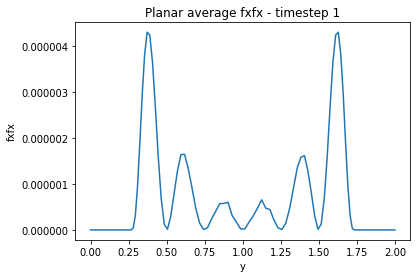

,y,Fx,Fy,Fz,fxfx,fyfy,fzfz,norm,v2,alpha,tke,tdr,rk,ux,uy,uz
0,0.000250,0,0,0,0,0,0,0,0.999998,0.714026,5.482647e-12,0.081737,1.170160,0.081556,1.000000,0.081556
11,0.000750,0,0,0,0,0,0,0,0.999993,1.237889,9.211710e-11,0.229010,1.510470,0.225089,1.000000,0.225089
24,0.001279,0,0,0,0,0,0,0,0.999992,2.921349,1.234596e-10,0.358514,1.845560,0.343904,0.911733,0.343904
29,0.001836,0,0,0,0,0,0,0,0.999993,6.701690,-3.327303e-09,0.474936,2.175440,0.442179,0.611446,0.442179
34,0.002426,0,0,0,0,0,0,0,0.999995,13.112693,-7.119841e-09,0.577896,2.489760,0.521135,0.439065,0.521135
36,0.003048,0,0,0,0,0,0,0,0.999998,21.844802,4.998338e-10,0.669885,2.788520,0.584905,0.336192,0.584905
46,0.003705,0,0,0,0,0,0,0,0.999999,33.742411,-7.295188e-10,0.753449,3.074581,0.637202,0.267519,0.637202
47,0.004399,0,0,0,0,0,0,0,0.999998,48.552886,-6.192985e-09,0.829742,3.347960,0.680338,0.219857,0.680338
48,0.005132,0,0,0,0,0,0,0,0.999998,66.962675,1.753302e-08,0.878606,3.529160,0.705720,0.185695,0.705720
52,0.005904,0,0,0,0,0,0,0,0.999998,83.983715,1.729747e-08,0.902156,3.618201,0.717346,0.160037,0.717346


In [45]:
NaluForcingPlot(NaluForceDF,"fxfx",1,True,False,0.0,6.29,0.995,1.005,False)

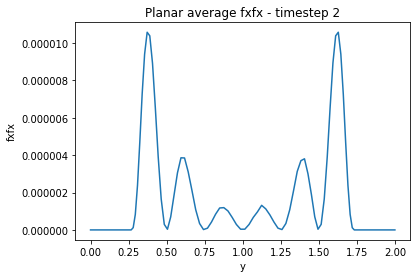

,y,Fx,Fy,Fz,fxfx,fyfy,fzfz,norm,v2,alpha,tke,tdr,rk,ux,uy,uz
0,0.000250,0,0,0,0,0,0,0,0.999995,0.714236,4.688327e-12,0.156122,1.336620,0.154866,1.000000,0.154866
11,0.000750,0,0,0,0,0,0,0,0.999985,1.238250,1.027991e-10,0.417694,2.009860,0.394986,1.000000,0.394986
24,0.001279,0,0,0,0,0,0,0,0.999981,2.923671,9.770037e-11,0.632510,2.665090,0.559778,0.915103,0.559778
29,0.001836,0,0,0,0,0,0,0,0.999984,6.708282,-3.248511e-09,0.817228,3.302320,0.673559,0.613356,0.673559
34,0.002426,0,0,0,0,0,0,0,0.999989,13.129903,-7.045675e-09,0.975581,3.902920,0.751146,0.440020,0.751146
36,0.003048,0,0,0,0,0,0,0,0.999996,21.878197,-4.721322e-10,1.113500,4.466890,0.805297,0.336659,0.805297
46,0.003705,0,0,0,0,0,0,0,0.999998,33.801502,2.806848e-09,1.236360,5.001290,0.844413,0.267621,0.844413
47,0.004399,0,0,0,0,0,0,0,0.999998,48.643008,-8.500735e-10,1.346510,5.506110,0.873227,0.219730,0.873227
48,0.005132,0,0,0,0,0,0,0,0.999998,67.091397,3.746347e-09,1.416190,5.837970,0.888801,0.185455,0.888801
52,0.005904,0,0,0,0,0,0,0,0.999998,83.960922,2.458136e-09,1.448850,5.996873,0.895466,0.159737,0.895466


In [47]:
NaluForcingPlot(NaluForceDF,"fxfx",2,True,False,0.0,6.29,0.995,1.005,False)

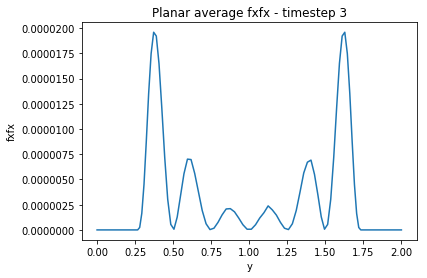

,y,Fx,Fy,Fz,fxfx,fyfy,fzfz,norm,v2,alpha,tke,tdr,rk,ux,uy,uz
0,0.000250,0,0,0,0,0,0,0,0.999992,0.714413,3.151673e-12,0.224418,1.499200,0.220725,1.000000,0.220725
11,0.000750,0,0,0,0,0,0,0,0.999977,1.238550,9.228254e-11,0.580380,2.497600,0.522942,1.000000,0.522942
24,0.001279,0,0,0,0,0,0,0,0.999971,2.924559,1.158162e-10,0.859631,3.458230,0.696067,0.915132,0.696067
29,0.001836,0,0,0,0,0,0,0,0.999976,6.710583,-3.150882e-09,1.093100,4.381079,0.798008,0.613359,0.798008
34,0.002426,0,0,0,0,0,0,0,0.999983,13.135299,-6.456690e-09,1.289470,5.241660,0.858987,0.439996,0.858987
36,0.003048,0,0,0,0,0,0,0,0.999993,21.888203,-1.759973e-09,1.457640,6.039980,0.897193,0.336625,0.897193
46,0.003705,0,0,0,0,0,0,0,0.999998,33.819095,2.606024e-09,1.605540,6.788860,0.922499,0.267575,0.922499
47,0.004399,0,0,0,0,0,0,0,0.999998,48.670716,-9.594516e-10,1.736480,7.488309,0.939817,0.219678,0.939817
48,0.005132,0,0,0,0,0,0,0,0.999998,67.133562,2.100284e-09,1.818810,7.945670,0.948719,0.185400,0.948719
52,0.005904,0,0,0,0,0,0,0,0.999998,83.985002,2.400194e-09,1.856740,8.160941,0.952376,0.159682,0.952376


In [48]:
NaluForcingPlot(NaluForceDF,"fxfx",3,True,False,0.0,6.29,0.995,1.005,False)

CDP - blue, Nalu - red


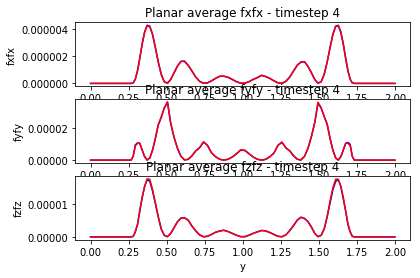

In [98]:
plotNaluTSs(NaluForceDF,"forcing",4,False,7)

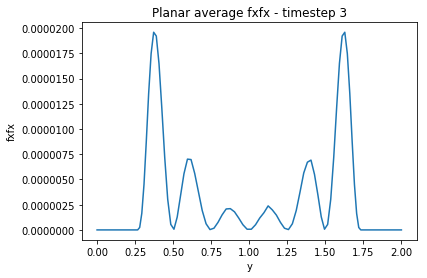

,y,Fx,Fy,Fz,fxfx,fyfy,fzfz,norm,v2,alpha,tke,tdr,rk,ux,uy,uz
0,0.000250,0,0,0,0,0,0,0,0.999992,0.714413,3.151673e-12,0.224418,1.499200,0.220725,1.000000,0.220725
11,0.000750,0,0,0,0,0,0,0,0.999977,1.238550,9.228254e-11,0.580380,2.497600,0.522942,1.000000,0.522942
24,0.001279,0,0,0,0,0,0,0,0.999971,2.924559,1.158162e-10,0.859631,3.458230,0.696067,0.915132,0.696067
29,0.001836,0,0,0,0,0,0,0,0.999976,6.710583,-3.150882e-09,1.093100,4.381079,0.798008,0.613359,0.798008
34,0.002426,0,0,0,0,0,0,0,0.999983,13.135299,-6.456690e-09,1.289470,5.241660,0.858987,0.439996,0.858987
36,0.003048,0,0,0,0,0,0,0,0.999993,21.888203,-1.759973e-09,1.457640,6.039980,0.897193,0.336625,0.897193
46,0.003705,0,0,0,0,0,0,0,0.999998,33.819095,2.606024e-09,1.605540,6.788860,0.922499,0.267575,0.922499
47,0.004399,0,0,0,0,0,0,0,0.999998,48.670716,-9.594516e-10,1.736480,7.488309,0.939817,0.219678,0.939817
48,0.005132,0,0,0,0,0,0,0,0.999998,67.133562,2.100284e-09,1.818810,7.945670,0.948719,0.185400,0.948719
52,0.005904,0,0,0,0,0,0,0,0.999998,83.985002,2.400194e-09,1.856740,8.160941,0.952376,0.159682,0.952376


In [46]:
NaluForcingPlot(NaluForceDF,"fxfx",3,True,False,0.0,6.29,0.995,1.005,False)

CDP - blue, Nalu - red


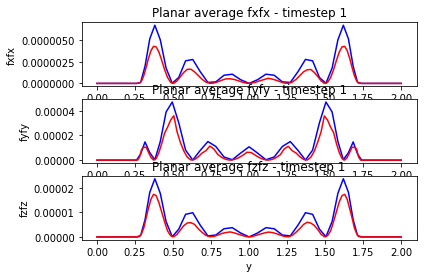

In [90]:
plotCDPvsNalu(cdpForceDF,NaluForceDF,"forcing",1,False,0.25,1.75,-.005,0.002,False,4)

In [3]:
def CDPprocessDS(fname):
  dset = tec.data.load_tecplot(fname,read_data_option=tec.constant.ReadDataOption.Replace)
  zone = dset.zone_names[0]
  print zone

  for var in dset.variable_names:
      varData = dset.variable(var).values(zone)
      dataFrameDict[var] = varData[:]  
        
  rawdata = pd.DataFrame(dataFrameDict)
  rawdata = rawdata.round(10)

  return rawdata

def plotCDPdataset(rdata,var,log,visc,plotHere,save):
  Retau = 1.0/visc #assumes a channel height of 1 and a utau of 1.0
  yCoords = rdata.y.unique()
    
  planarAvg = np.zeros((len(yCoords),22))
  index = 0
  for yc in yCoords:
    sliceY = rdata.loc[(rdata['y'] == yc)]
    avgUx = sliceY.ux.sum()/len(sliceY)
    avgUy = sliceY.uy.sum()/len(sliceY)
    avgUz = sliceY.uz.sum()/len(sliceY)
    avgAvgUx = sliceY.avgUx.sum()/len(sliceY)
    avgAvgUy = sliceY.avgUy.sum()/len(sliceY)
    avgAvgUz = sliceY.avgUz.sum()/len(sliceY)
    avgAlpha = sliceY.alpha.sum()/len(sliceY)
    avgTke = sliceY.tke.sum()/len(sliceY)
    avgTdr = sliceY.tdr.sum()/len(sliceY)
    avgRk = sliceY.rk.sum()/len(sliceY)
    avgAvgRk = sliceY.avgRk.sum()/len(sliceY)
    avgKres = sliceY.kres.sum()/len(sliceY)
    avgAvgProd = sliceY.avgProd.sum()/len(sliceY)
    avgTvisc = sliceY.tvisc.sum()/len(sliceY)
    avgAltTvisc = sliceY.altTvisc.sum()/len(sliceY)
    avgTimeDES = sliceY.timeDES.sum()/len(sliceY)
    avgRANStime = sliceY.RANStime.sum()/len(sliceY)
    avgV2 = sliceY.v2.sum()/len(sliceY)
    uuVar = sliceY.varUx.sum()/len(sliceY)
    vvVar = sliceY.varUy.sum()/len(sliceY)
    wwVar = sliceY.varUz.sum()/len(sliceY)
    planarAvg[index] = np.array([yc/visc,avgUx,avgUy,avgUz,avgAvgUx,avgAvgUy,avgAvgUz,avgAlpha,avgTke,avgTdr,avgRk,avgAvgRk,avgKres,avgAvgProd,avgTvisc,avgAltTvisc,avgTimeDES,avgRANStime,avgV2,uuVar,vvVar,wwVar])
    #planarAvg[index] = np.array([yc/visc,avgUx,avgUy,avgUz,avgAvgUx,avgAvgUy,avgAvgUz,avgAlpha,avgTke,avgRk,avgAvgRk,avgKres,avgAvgProd,avgTvisc])
    index = index + 1
    
  pltFrame = pd.DataFrame(planarAvg,columns=['y','ux','uy','uz','avgUx','avgUy','avgUz','alpha','tke','tdr','rk','avgRk','kres','avgProd','tvisc','altTvisc','avgTime','RANStime','v2','uuVar','vvVar','wwVar'])
  #pltFrame = pd.DataFrame(planarAvg,columns=['y','ux','uy','uz','avgUx','avgUy','avgUx','alpha','tke','rk','avgRk','kres','avgProd','tvisc'])
  
  pltFrame = pltFrame.loc[(pltFrame['y'] <= 1.0/visc)]
  pltFrame = pltFrame.sort_values(by=['y'])

  if (plotHere):
      fig = plt.figure()
      ax = fig.add_subplot(1,1,1)
      ax.plot(pltFrame.y,pltFrame[var])

      if (log):
          ax.set_xscale('log')
      if (save):
          plt.savefig('/workspace/jmelvin/Research/channelFlow/alphaMovies/cdp_' + zone[5:-1])
          plt.close(fig)
        
      if (not save):
          plt.show()

  return pltFrame


def NALUprocessDS(bname,numPart,ts):
    for j in range(0,numPart):
        if (numPart > 1):
            fn = bname + "." + str(numPart) + "." + str(j).zfill(1)
            if (numPart >= 10):
                fn = bname + "." + str(numPart) + "." + str(j).zfill(2)
            if (numPart >= 100):
                fn = bname + "." + str(numPart) + "." + str(j).zfill(3)
            if (numPart >= 1000):
                fn = bname + "." + str(numPart) + "." + str(j).zfill(4)
            f = nc.Dataset(fn,"r")
    
            x = f['coordx']
            y = f['coordy']
            z = f['coordz']
            
            #print j

            for i in range(0,f.dimensions["num_nod_var"].size):
                if (''.join(f["name_nod_var"][i].data) == "average_velocity_x"):
                    avgUx = f["vals_nod_var%i" % (i+1)][ts]
                if (''.join(f["name_nod_var"][i].data) == "average_velocity_y"):
                    avgUy = f["vals_nod_var%i" % (i+1)][ts]
                if (''.join(f["name_nod_var"][i].data) == "average_velocity_z"):
                    avgUz = f["vals_nod_var%i" % (i+1)][ts]
                if (''.join(f["name_nod_var"][i].data) == "velocity_x"):
                    ux = f["vals_nod_var%i" % (i+1)][ts]
                if (''.join(f["name_nod_var"][i].data) == "velocity_y"):
                    uy = f["vals_nod_var%i" % (i+1)][ts]
                if (''.join(f["name_nod_var"][i].data) == "velocity_z"):
                    uz = f["vals_nod_var%i" % (i+1)][ts]
                if (''.join(f["name_nod_var"][i].data) == "k_ratio"):
                    alpha = f["vals_nod_var%i" % (i+1)][ts]
                if (''.join(f["name_nod_var"][i].data) == "turbulent_ke"):
                    tke = f["vals_nod_var%i" % (i+1)][ts]
                if (''.join(f["name_nod_var"][i].data) == "specific_dissipation_rate"):
                    tdr = f["vals_nod_var%i" % (i+1)][ts]
                if (''.join(f["name_nod_var"][i].data) == "average_tke_resolved"):
                    kres = f["vals_nod_var%i" % (i+1)][ts]
                if (''.join(f["name_nod_var"][i].data) == "average_production"):
                    avgProd = f["vals_nod_var%i" % (i+1)][ts]
                if (''.join(f["name_nod_var"][i].data) == "turbulent_viscosity"): #"rans_time_scale"):
                    avgTime = f["vals_nod_var%i" % (i+1)][ts]
                if (''.join(f["name_nod_var"][i].data) == "turbulent_viscosity"):
                    tvisc = f["vals_nod_var%i" % (i+1)][ts]
                if (''.join(f["name_nod_var"][i].data) == "resolution_adequacy_parameter"):
                    rk = f["vals_nod_var%i" % (i+1)][ts]
                if (''.join(f["name_nod_var"][i].data) == "avg_res_adequacy_parameter"):
                    avgRk = f["vals_nod_var%i" % (i+1)][ts]
            for i in range(0,f.dimensions["num_elem_var"].size):
                if (''.join(f["name_elem_var"][i].data) == "resolution_adequacy_parameter"):
                    rkElem = f["vals_elem_var%ieb1" % (i+1)][ts]
                    nodalRk = np.zeros(f.dimensions["num_nodes"].size)
                    countRk = np.zeros(f.dimensions["num_nodes"].size)
                    elemCnt = 0
                    for elem in f["connect1"][:]:
                        for nodeID in elem:
                            nodalRk[nodeID-1] += rkElem[elemCnt]
                            countRk[nodeID-1] += 1
                        elemCnt = elemCnt + 1
                    rk = nodalRk/countRk
                if (''.join(f["name_elem_var"][i].data) == "average_resolution_adequacy_para"):
                    avgRkElem = f["vals_elem_var%ieb1" % (i+1)][ts]
                    nodalAvgRk = np.zeros(f.dimensions["num_nodes"].size)
                    countAvgRk = np.zeros(f.dimensions["num_nodes"].size)
                    elemCnt = 0
                    for elem in f["connect1"][:]:
                        for nodeID in elem:
                            nodalAvgRk[nodeID-1] += avgRkElem[elemCnt]
                            countAvgRk[nodeID-1] += 1
                        elemCnt = elemCnt + 1
                    avgRk = nodalAvgRk/countAvgRk
 
            if (j == 0):
                print f["time_whole"][ts]
                rawdata = pd.DataFrame({'x':x[:],'y':y[:],'z':z[:],'ux':ux[:],'uy':uy[:],'uz':uz[:],'avgUx':avgUx[:],'avgUy':avgUy[:],'avgUz':avgUz[:],'alpha':alpha[:],'tke':tke[:],'tdr':tdr[:],'kres':kres[:],'avgProd':avgProd[:],'avgTime':avgTime[:],'tvisc':tvisc[:],'rk':rk[:],'avgRk':avgRk[:]})
                #rawdata = pd.DataFrame({'x':x[:],'y':y[:],'z':z[:],'ux':ux[:],'uy':uy[:],'uz':uz[:],'tke':tke[:],'tvisc':tvisc[:]})
                #rawdata = pd.DataFrame({'x':x[:],'y':y[:],'z':z[:],'ux':ux[:],'uy':uy[:],'uz':uz[:],'avgUx':avgUx[:],'avgUy':avgUy[:],'avgUz':avgUz[:],'alpha':alpha[:],'tke':tke[:],'tdr':tdr[:],'kres':kres[:],'tvisc':tvisc[:]})
            else:
                tmpdata = pd.DataFrame({'x':x[:],'y':y[:],'z':z[:],'ux':ux[:],'uy':uy[:],'uz':uz[:],'avgUx':avgUx[:],'avgUy':avgUy[:],'avgUz':avgUz[:],'alpha':alpha[:],'tke':tke[:],'tdr':tdr[:],'kres':kres[:],'avgProd':avgProd[:],'avgTime':avgTime[:],'tvisc':tvisc[:],'rk':rk[:],'avgRk':avgRk[:]})
                #tmpdata = pd.DataFrame({'x':x[:],'y':y[:],'z':z[:],'ux':ux[:],'uy':uy[:],'uz':uz[:],'tke':tke[:],'tvisc':tvisc[:]})
                #tmpdata = pd.DataFrame({'x':x[:],'y':y[:],'z':z[:],'ux':ux[:],'uy':uy[:],'uz':uz[:],'avgUx':avgUx[:],'avgUy':avgUy[:],'avgUz':avgUz[:],'alpha':alpha[:],'tke':tke[:],'tdr':tdr[:],'kres':kres[:],'tvisc':tvisc[:]})
                rawdata = pd.concat([rawdata,tmpdata])
        
        else:
            fn = bname
            f = nc.Dataset(fn,"r")
    
            x = f['coordx']
            y = f['coordy']
            z = f['coordz']

            print f["time_whole"][ts]

            for i in range(0,f.dimensions["num_nod_var"].size):
                if (''.join(f["name_nod_var"][i].data) == "average_velocity_x"):
                    avgUx = f["vals_nod_var%i" % (i+1)][ts]
                if (''.join(f["name_nod_var"][i].data) == "average_velocity_y"):
                    avgUy = f["vals_nod_var%i" % (i+1)][ts]
                if (''.join(f["name_nod_var"][i].data) == "average_velocity_z"):
                    avgUz = f["vals_nod_var%i" % (i+1)][ts]
                if (''.join(f["name_nod_var"][i].data) == "velocity_x"):
                    ux = f["vals_nod_var%i" % (i+1)][ts]
                if (''.join(f["name_nod_var"][i].data) == "velocity_y"):
                    uy = f["vals_nod_var%i" % (i+1)][ts]
                if (''.join(f["name_nod_var"][i].data) == "velocity_z"):
                    uz = f["vals_nod_var%i" % (i+1)][ts]
                if (''.join(f["name_nod_var"][i].data) == "k_ratio"):
                    alpha = f["vals_nod_var%i" % (i+1)][ts]
                if (''.join(f["name_nod_var"][i].data) == "turbulent_ke"):
                    tke = f["vals_nod_var%i" % (i+1)][ts]
                if (''.join(f["name_nod_var"][i].data) == "specific_dissipation_rate"):
                    tdr = f["vals_nod_var%i" % (i+1)][ts]
                if (''.join(f["name_nod_var"][i].data) == "average_tke_resolved"):
                    kres = f["vals_nod_var%i" % (i+1)][ts]
                if (''.join(f["name_nod_var"][i].data) == "average_production"):
                    avgProd = f["vals_nod_var%i" % (i+1)][ts]
                if (''.join(f["name_nod_var"][i].data) == "rans_time_scale"):
                    avgTime = f["vals_nod_var%i" % (i+1)][ts]
                if (''.join(f["name_nod_var"][i].data) == "turbulent_viscosity"):
                    tvisc = f["vals_nod_var%i" % (i+1)][ts]
                if (''.join(f["name_nod_var"][i].data) == "resolution_adequacy_parameter"):
                    rk = f["vals_nod_var%i" % (i+1)][ts]
                if (''.join(f["name_nod_var"][i].data) == "avg_res_adequacy_parameter"):
                    avgRk = f["vals_nod_var%i" % (i+1)][ts]
            for i in range(0,f.dimensions["num_elem_var"].size):
                if (''.join(f["name_elem_var"][i].data) == "resolution_adequacy_parameter"):
                    rkElem = f["vals_elem_var%ieb1" % (i+1)][ts]
                    nodalRk = np.zeros(f.dimensions["num_nodes"].size)
                    countRk = np.zeros(f.dimensions["num_nodes"].size)
                    elemCnt = 0
                    for elem in f["connect1"][:]:
                        for nodeID in elem:
                            nodalRk[nodeID-1] += rkElem[elemCnt]
                            countRk[nodeID-1] += 1
                        elemCnt = elemCnt + 1
                    rk = nodalRk/countRk
                if (''.join(f["name_elem_var"][i].data) == "average_resolution_adequacy_para"):
                    avgRkElem = f["vals_elem_var%ieb1" % (i+1)][ts]
                    nodalAvgRk = np.zeros(f.dimensions["num_nodes"].size)
                    countAvgRk = np.zeros(f.dimensions["num_nodes"].size)
                    elemCnt = 0
                    for elem in f["connect1"][:]:
                        for nodeID in elem:
                            nodalAvgRk[nodeID-1] += avgRkElem[elemCnt]
                            countAvgRk[nodeID-1] += 1
                        elemCnt = elemCnt + 1
                    avgRk = nodalRk/countRk  
                    
            rawdata = pd.DataFrame({'x':x[:],'y':y[:],'z':z[:],'ux':ux[:],'uy':uy[:],'uz':uz[:],'avgUx':avgUx[:],'avgUy':avgUy[:],'avgUz':avgUz[:],'alpha':alpha[:],'tke':tke[:],'tdr':tdr[:],'rk':rk[:],'avgRk':avgRk[:],'kres':kres[:],'avgProd':avgProd[:],'avgTime':avgTime[:],'tvisc':tvisc[:],'rk':rk[:],'avgRk':avgRk[:]})
            #rawdata = pd.DataFrame({'x':x[:],'y':y[:],'z':z[:],'ux':ux[:],'uy':uy[:],'uz':uz[:],'tke':tke[:],'tvisc':tvisc[:]})

#            rawdata = pd.DataFrame({'x':x[:],'y':y[:],'z':z[:],'ux':ux[:],'uy':uy[:],'uz':uz[:],'avgUx':avgUx[:],'avgUy':avgUy[:],'avgUz':avgUz[:],'alpha':alpha[:],'tke':tke[:],'tdr':tdr[:],'rk':rk[:],'avgRk':avgRk[:],'kres':kres[:],'tvisc':tvisc[:]})

    rawdata = rawdata.round(10)
    rawdata["fluctUx"] = rawdata["ux"] - rawdata["avgUx"]
    rawdata["fluctUy"] = rawdata["uy"] - rawdata["avgUy"]
    rawdata["fluctUz"] = rawdata["uz"] - rawdata["avgUz"]
    rawdata["varUx"] = rawdata["fluctUx"]*rawdata["fluctUx"]
    rawdata["varUy"] = rawdata["fluctUy"]*rawdata["fluctUy"]
    rawdata["varUz"] = rawdata["fluctUz"]*rawdata["fluctUz"]
    rawdata["RANStime"] = rawdata["tke"]/rawdata["tdr"]
    
    return rawdata


def plotNaludataset(rdata,var,log,visc,ts,plotHere,save):
  Retau = 1.0/visc #assumes a channel halfwidth of 1 and a utau of 1.0
  yCoords = rdata.y.unique()
    
  planarAvg = np.zeros((len(yCoords),20))
  index = 0
  for yc in yCoords:
      sliceY = rdata.loc[(rdata['y'] == yc)]
      avgUx = sliceY.ux.sum()/len(sliceY)
      avgUy = sliceY.uy.sum()/len(sliceY)
      avgUz = sliceY.uz.sum()/len(sliceY)
      avgAvgUx = sliceY.avgUx.sum()/len(sliceY)
      avgAvgUy = sliceY.avgUy.sum()/len(sliceY)
      avgAvgUz = sliceY.avgUz.sum()/len(sliceY)
      avgAlpha = sliceY.alpha.sum()/len(sliceY)
      avgTke = sliceY.tke.sum()/len(sliceY)
      avgTdr = sliceY.tdr.sum()/len(sliceY)
      avgRk = sliceY.rk.sum()/len(sliceY)
      avgAvgRk = sliceY.avgRk.sum()/len(sliceY)
      avgKres = sliceY.kres.sum()/len(sliceY)
      avgAvgProd = sliceY.avgProd.sum()/len(sliceY)
      avgAvgTime = sliceY.avgTime.sum()/len(sliceY)
      avgTvisc = sliceY.tvisc.sum()/len(sliceY)
      avgRANStime = sliceY.RANStime.sum()/len(sliceY)
      uuVar = sliceY.varUx.sum()/len(sliceY)
      vvVar = sliceY.varUy.sum()/len(sliceY)
      wwVar = sliceY.varUz.sum()/len(sliceY)
      planarAvg[index] = np.array([yc/visc,avgUx,avgUy,avgUz,avgAvgUx,avgAvgUy,avgAvgUz,avgAlpha,avgTke,uuVar,vvVar,wwVar,avgTdr,avgKres,avgAvgProd,avgAvgTime,avgTvisc,avgRANStime,avgRk,avgAvgRk])
#      planarAvg[index] = np.array([yc/visc,avgUx,avgUy,avgUz,avgTke,avgTvisc])
#      planarAvg[index] = np.array([yc/visc,avgUx,avgUy,avgUz,avgAvgUx,avgAvgUy,avgAvgUz,avgAlpha,avgTke,uuVar,vvVar,wwVar,avgTdr,avgKres,avgTvisc])
      index = index + 1
    
  pltFrame = pd.DataFrame(planarAvg,columns=['y','ux','uy','uz','avgUx','avgUy','avgUz','alpha','tke','uuVar','vvVar','wwVar','tdr','kres','avgProd','avgTime','tvisc','RANStime','rk','avgRk'])
#  pltFrame = pd.DataFrame(planarAvg,columns=['y','ux','uy','uz','tke','tvisc'])
#  pltFrame = pd.DataFrame(planarAvg,columns=['y','ux','uy','uz','avgUx','avgUy','avgUz','alpha','tke','uu','vv','ww','tdr','kres','tvisc'])
    
  pltFrame = pltFrame.loc[(pltFrame['y'] <= 1.0/visc)]
  pltFrame = pltFrame.sort_values(by=['y'])

  if (plotHere):
      fig = plt.figure()
      ax = fig.add_subplot(1,1,1)
      ax.plot(pltFrame.y,pltFrame[var])
      #ax.set_ylim(0.0,25.0)

      if (log):
          ax.set_xscale('log')
      if (save):
          plt.savefig('/workspace/jmelvin/Research/channelFlow/alphaMovies/nalu_' + str(ts).zfill(4))
          plt.close(fig)
      else:
          plt.show()

  return pltFrame

def DSplotCDP(fnameCDP,var,log,visc,ts,save,DNS,dnsPath):
  cdpData = CDPprocessDS(fnameCDP)
  cdpPlot = plotCDPdataset(cdpData,var,log,visc,False,False)
#  if (var != "forcing"):
  fig, ax = plt.subplots()
  ax.plot(cdpPlot.y,cdpPlot[var],'b',linewidth=4)
  if (DNS):
    DNSdata = pd.read_csv(dnsPath, delim_whitespace=True)
    if (var == 'tke'):
        ax.plot(DNSdata["y^+"],DNSdata["k"],'k',linewidth=3)
    elif (var == 'ux'):
        ax.plot(DNSdata["y^+"],DNSdata["U"],'k',linewidth=3)
    elif (var == 'avgUx'):
        ax.plot(DNSdata["y^+"],DNSdata["U"],'k',linewidth=3)
  ax.set(xlabel='y',ylabel="%s" % var,title="Planar average %s - timestep %i" % (var,ts))
  if (log):
      ax.set_xscale('log')
      ax.set_xlim([1, 1./visc])
  if (save):
      plt.tight_layout()
      plt.savefig('/workspace/jmelvin/Research/dataAnalysis/CDP_' + var + "_" + str(ts).zfill(4))
      plt.close(fig)
  else:
      print "CDP - blue"
      plt.show()
    
def DSplotCDPvsNalu(fnameCDP,bnameNalu,numPartNalu,var,log,visc,ts,save,DNS,dnsPath,customAxes,xL,xH,yL,yH):
  cdpPlot = []
  colors = ['b','r','g','c','m','y','w',]
  for item in fnameCDP:
    cdpData = CDPprocessDS(item)
    cdpPlot.append(plotCDPdataset(cdpData,var,log,visc,False,False))
  naluPlot = []
  for (item, npart) in zip(bnameNalu, numPartNalu):
    naluData = NALUprocessDS(item,npart,ts)
    naluPlot.append(plotNaludataset(naluData,var,log,visc,ts,False,False))
  for varItem in var:
    fig, ax = plt.subplots()
    colorID = 0
    for item in cdpPlot:
      ax.plot(item.y,item[varItem],colors[colorID],linewidth=4)
      colorID = colorID + 1
    for item in naluPlot:
      if (varItem == 'altTvisc'):
        ax.plot(item.y,item['tvisc'],colors[colorID],linewidth=4)
      else:
        ax.plot(item.y,item[varItem],colors[colorID],linewidth=4)
      colorID = colorID + 1
    if (varItem == "ux"):
      DNS = True
      dnsPath = '/workspace/jmelvin/NaluProject/TAMS-Implemenation-testing/channelFlow/channelFlow/dns_data/Re5200.txt'
    elif (varItem == "tke"):
      DNS = True
      dnsPath = '/workspace/jmelvin/NaluProject/TAMS-Implemenation-testing/channelFlow/channelFlow/dns_data/tke-Re5200.txt'
    else:
      DNS = False
    if (DNS):
      DNSdata = pd.read_csv(dnsPath, delim_whitespace=True)
      if (varItem == 'tke'):
          ax.plot(DNSdata["y^+"],DNSdata["k"],'k',linewidth=3)
      elif (varItem == 'ux'):
          ax.plot(DNSdata["y^+"],DNSdata["U"],'k',linewidth=3)
      elif (varItem == 'avgUx'):
          ax.plot(DNSdata["y^+"],DNSdata["U"],'k',linewidth=3)
    ax.set(xlabel='y',ylabel="%s" % varItem,title="Planar average %s" % (varItem))
    if (log):
        ax.set_xscale('log')
        ax.set_xlim([1, 1./visc])
    if (customAxes):
        ax.set_xlim(xL,xH)
        ax.set_ylim(yL,yH)
    for label in ax.get_xticklabels():
        label.set_fontsize(16)
    for label in ax.get_yticklabels():
        label.set_fontsize(16)  
    ax.xaxis.label.set_size(16)
    ax.yaxis.label.set_size(16)
    ax.title.set_size(16)
    if (save):
        plt.tight_layout()
        plt.savefig('/workspace/jmelvin/Research/dataAnalysis/CDPvsNalus_' + varItem + "_" + str(ts).zfill(4))
        plt.close(fig)
    else:
        plt.show()
        
def DSplotNaluvsNalu(bnameNalu1,numPartNalu1,bnameNalu2,numPartNalu2,var,log,visc,ts,save,DNS,dnsPath,customAxes,xL,xH,yL,yH):
  naluData1 = NALUprocessDS(bnameNalu1,numPartNalu1,ts)
  naluData2 = NALUprocessDS(bnameNalu2,numPartNalu2,ts)
  naluPlot1 = plotNaludataset(naluData1,var,log,visc,ts,False,False)
  naluPlot2 = plotNaludataset(naluData2,var,log,visc,ts,False,False)
#  if (var != "forcing"):
  fig, ax = plt.subplots()
  ax.plot(naluPlot1.y,naluPlot1[var],'b',linewidth=4)
  ax.plot(naluPlot2.y,naluPlot2[var],'r',linewidth=4)
  if (DNS):
    DNSdata = pd.read_csv(dnsPath, delim_whitespace=True)
    if (var == 'tke'):
        ax.plot(DNSdata["y^+"],DNSdata["k"],'k',linewidth=3)
    elif (var == 'ux'):
        ax.plot(DNSdata["y^+"],DNSdata["U"],'k',linewidth=3)
    elif (var == 'avgUx'):
        ax.plot(DNSdata["y^+"],DNSdata["U"],'k',linewidth=3)
  ax.set(xlabel='y',ylabel="%s" % var,title="Planar average %s - timestep %i" % (var,ts))
  ax.set_xlim(1,1/visc)
  if (log):
      ax.set_xscale('log')
  if (customAxes):
      ax.set_xlim(xL,xH)
      ax.set_ylim(yL,yH)
#  else:
#      fig = plt.figure()
#      ax1 = plt.subplot(311)
#      ax1.plot(cdpPlot.y,cdpPlot['fxfx'])
#      ax1.plot(naluPlot.y,naluPlot['fxfx'])
#      ax1.set(xlabel='y',ylabel="%s" % 'fxfx',title="Planar average %s - timestep %i" % ('fxfx',ts)) 
#      ax2 = plt.subplot(312)
#      ax2.plot(cdpPlot.y,cdpPlot['fyfy'])
#      ax2.plot(naluPlot.y,naluPlot['fyfy'])
#      ax2.set(xlabel='y',ylabel="%s" % 'fyfy',title="Planar average %s - timestep %i" % ('fyfy',ts)) 
#      ax3 = plt.subplot(313)
#      ax3.plot(cdpPlot.y,cdpPlot['fzfz'])
#      ax3.plot(naluPlot.y,naluPlot['fzfz'])
#      ax3.set(xlabel='y',ylabel="%s" % 'fzfz',title="Planar average %s - timestep %i" % ('fzfz',ts)) 

  if (save):
      plt.tight_layout()
      plt.savefig('/workspace/jmelvin/Research/dataAnalysis/NaluvsNalu_' + var + "_" + str(ts).zfill(4))
      plt.close(fig)
  else:
      plt.show()

SyntaxError: Missing parentheses in call to 'print'. Did you mean print(zone)? (<ipython-input-3-6852d79aabf3>, line 4)

559.999999999181


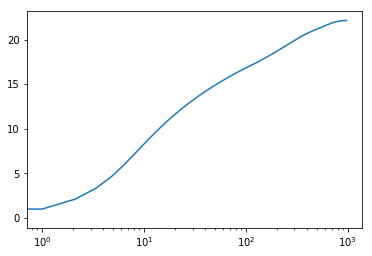

,y,ux,uy,uz,avgUx,avgUy,avgUz,alpha,tke,uuVar,vvVar,wwVar,tdr,kres,avgProd,tvisc,rk,avgRk
0,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,1.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
1,1.000512,1.014945,-2.075948e-07,-0.001067,1.014528,-2.998198e-07,-0.001111,0.999962,0.052467,0.000003,5.916470e-12,8.254471e-07,5.703555,0.000002,4.370495,0.000004,30.000000,30.000000
2,2.116288,2.132212,-3.469981e-07,-0.002328,2.131796,-3.771689e-07,-0.002384,0.999986,0.267841,0.000006,3.238913e-11,1.991922e-06,21.637125,0.000004,23.036903,0.000024,30.000000,30.000000
3,3.360455,3.339731,-1.196404e-07,-0.004193,3.339273,2.897378e-09,-0.004253,0.999992,0.673863,0.000008,1.026661e-10,2.978378e-06,43.862724,0.000005,58.838947,0.000066,30.000000,30.000000
4,4.747597,4.615452,-7.303827e-07,-0.005654,4.614978,-4.840861e-07,-0.005741,0.999995,1.277539,0.000009,2.478090e-10,3.707131e-06,69.947426,0.000006,107.049748,0.000139,30.000000,30.000000
5,6.293912,5.911020,2.471860e-06,-0.007474,5.910461,2.796620e-06,-0.007570,0.999996,2.033220,0.000012,5.962515e-10,5.266332e-06,96.312934,0.000009,163.314536,0.000270,30.000000,30.000000
6,8.017371,7.152408,3.729543e-07,-0.008502,7.151708,2.380774e-07,-0.008630,0.999995,2.824674,0.000019,1.671040e-09,9.415917e-06,117.941288,0.000014,225.872257,0.000537,30.000000,30.000000
7,9.937908,8.271896,3.412563e-06,-0.010516,8.270939,3.698732e-06,-0.010659,0.999994,3.503906,0.000027,4.136607e-09,1.521003e-05,129.990086,0.000021,249.287883,0.000919,30.000000,30.000000
8,12.077608,9.265745,-8.297857e-08,-0.011460,9.264555,-1.499756e-07,-0.011675,0.999993,4.015172,0.000037,9.177144e-09,2.281580e-05,132.725146,0.000030,242.584071,0.001420,30.000000,30.000000
9,14.460923,10.140711,3.988990e-06,-0.012035,10.139279,2.401955e-06,-0.012306,0.999991,4.359652,0.000049,1.904827e-08,3.309048e-05,128.488078,0.000041,220.190295,0.002043,30.000000,30.000000


In [69]:
naluDS = NALUprocessDS('/workspace/jmelvin/Research/dataFiles/Nalu-Best_70119/TAMS-KEps-Re1000-debug.e',36,50)
plotNaludataset(naluDS,'ux',True,0.000999488,50,True,False)

In [3]:
stepNum = 0
dnsfn = '/workspace/jmelvin/Research/channelFlow/channelFlow/dns_data/Re1000.txt'
nalubn2 = '/workspace/jmelvin/Research/dataFiles/Nalu-debug-82119/TAMS-KEps-Re1000-82119.e'
naluNP2 = 1
nalubn1 = '/workspace/jmelvin/Research/dataFiles/Nalu-debug-82119/KEps-Re1000-82119.e'
naluNP1 = 1
visco = 0.000999488 # 0.000192831 
DSplotNaluvsNalu(nalubn1,naluNP1,nalubn2,naluNP2,"tke",True,visco,stepNum,False,False,dnsfn,False,100,1000,-0.1,1.5)

IOError: [Errno 2] No such file or directory: '/workspace/jmelvin/Research/dataFiles/Nalu-debug-82119/KEps-Re1000-82119.e'

step 020000
step 020800
step 021600


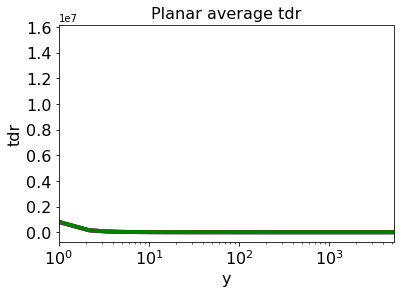

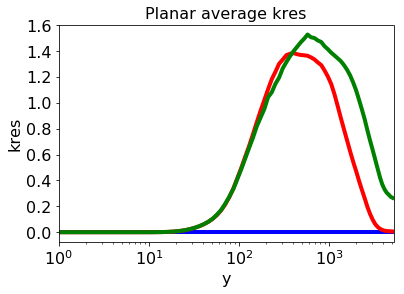

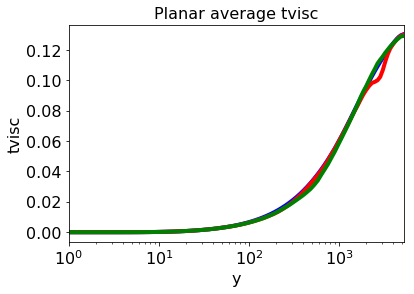

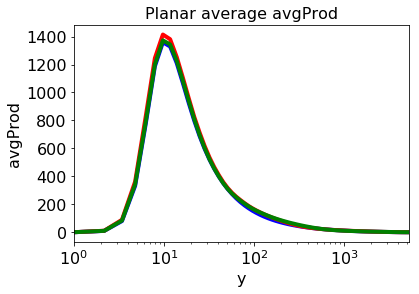

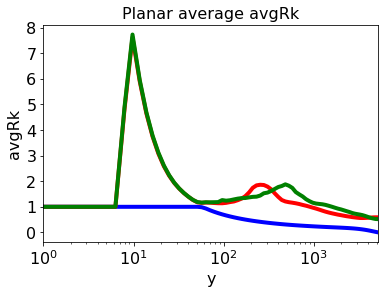

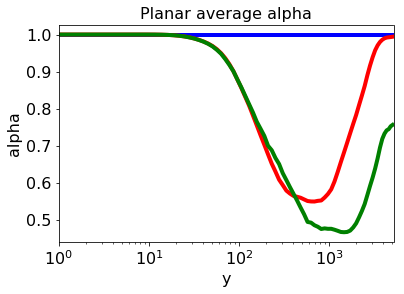

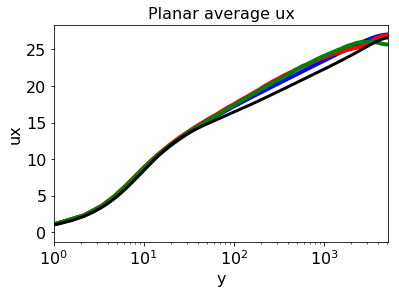

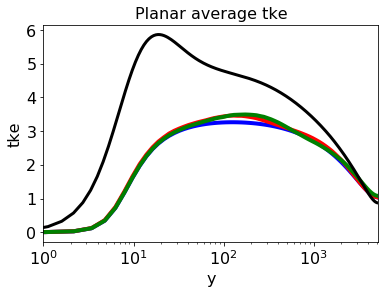

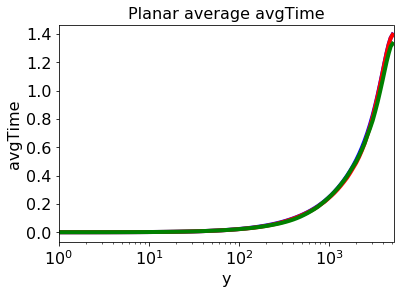

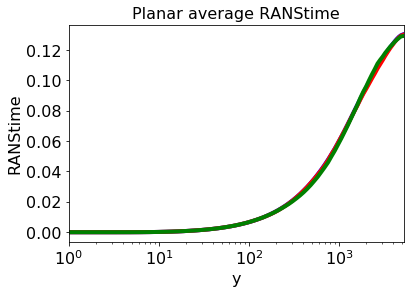

In [8]:
stepNum = 200
dnsfn = '/workspace/jmelvin/NaluProject/TAMS-Implemenation-testing/channelFlow/dns_data/Re5200.txt'
cdpfn = [
    '/workspace/jmelvin/NaluProject/TAMS-Implemenation-testing/dataFiles/CDP-SSTFIX-5200/SST5200.020000.plt',
    '/workspace/jmelvin/NaluProject/TAMS-Implemenation-testing/dataFiles/CDP-SSTFIX-5200/TAMS-SST5200.020800.plt',
    '/workspace/jmelvin/NaluProject/TAMS-Implemenation-testing/dataFiles/CDP-SSTFIX-5200/TAMS-SST5200.021600.plt',
]
nalubn = [
    #'/workspace/jmelvin/NaluProject/TAMS-Implemenation-testing/dataFiles/Nalu-SST5200/TAMS-SST-Re5200.e'
    #'/workspace/jmelvin/NaluProject/TAMS-Implemenation-testing/dataFiles/Nalu-SST-isoProdBack/TAMS-SST-Re1000-noEqs-isoProdBack.e',
    #'/workspace/jmelvin/NaluProject/TAMS-Implemenation-testing/dataFiles/Nalu-SST-segSolver/TAMS-SST-Re1000-segSolver.e',
    #'/workspace/jmelvin/NaluProject/TAMS-Implemenation-testing/dataFiles/masterPush/TAMS-SST-Re1000-noEqs-finalPush.e'

]
naluNP = [144]
visco = 0.000192831 # 0.000999488 # 0.000192831 
DSplotCDPvsNalu(cdpfn,nalubn,naluNP,["tdr","kres","tvisc","avgProd","avgRk","alpha","ux","tke","avgTime","RANStime"],True,visco,0,False,False,dnsfn,False,200,1000,0.0,1.4)

step 020000
step 100000


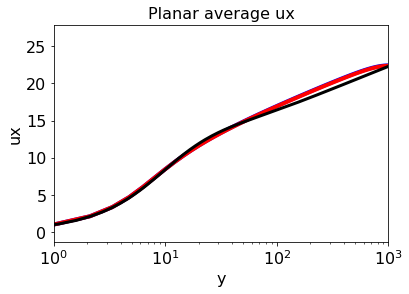

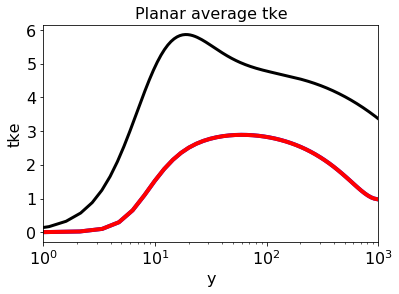

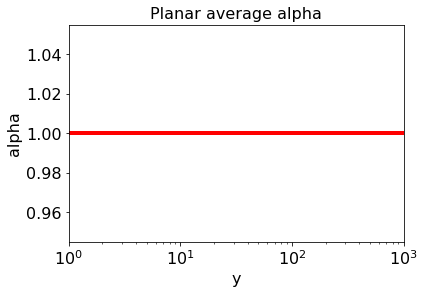

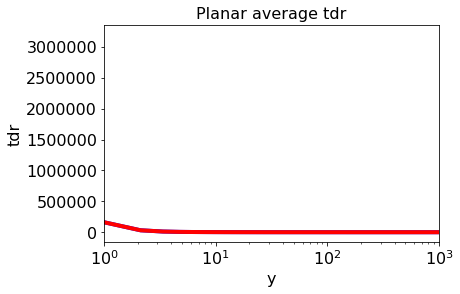

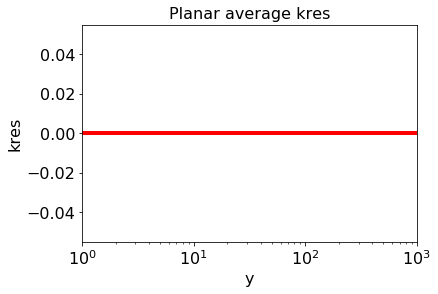

In [6]:
stepNum = 30
dnsfn = '/workspace/jmelvin/Research/channelFlow/channelFlow/dns_data/Re1000.txt'
#dnsfn = '/workspace/jmelvin/Research/channelFlow/channelFlow/dns_data/tke-Re1000.txt'
cdpfn = [
    '/workspace/jmelvin/NaluProject/TAMS-Implemenation-testing/dataFiles/CDP-NewVersion-021820/SST1000.020000.plt',
    '/workspace/jmelvin/NaluProject/TAMS-Implemenation-testing/dataFiles/cdp-RANS-SST-1000/SST1000.100000.plt'

]
nalubn=[
    #'/workspace/jmelvin/Research/dataFiles/cdp-SST-debug/TAMS-SST-Re1000-newRANSsoln.e'
]
naluNP = [36]
visco = 0.000999488 # 0.000192831 
DSplotCDPvsNalu(cdpfn,nalubn,naluNP,["ux","tke","alpha","tdr","kres"],True,visco,stepNum,False,False,dnsfn,False,100,1000,-0.1,1.4)

300.79999999985324


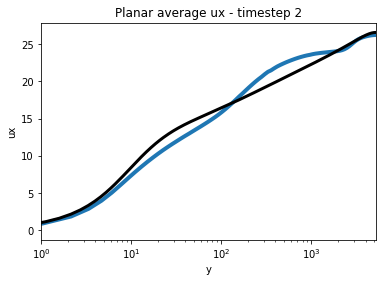

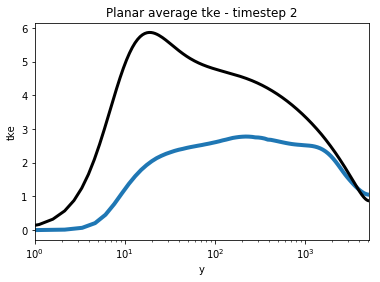

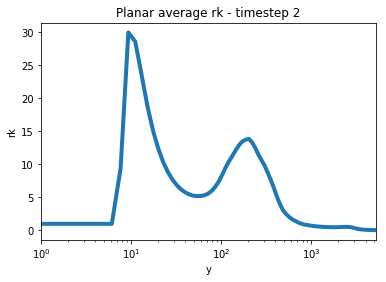

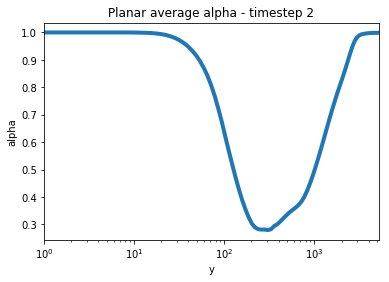

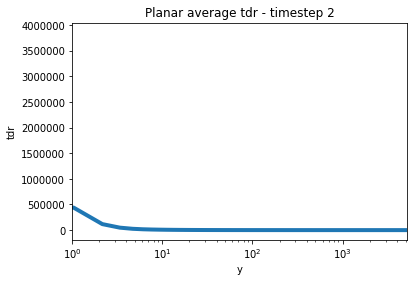

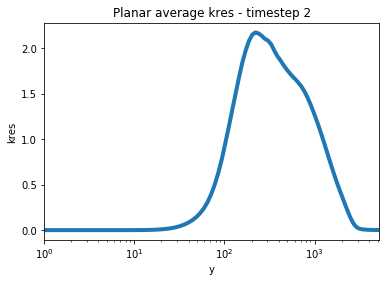

In [27]:
stepNum = 2
dnsfn = '/workspace/jmelvin/Research/channelFlow/channelFlow/dns_data/Re1000.txt'
#dnsfn = '/workspace/jmelvin/Research/channelFlow/channelFlow/dns_data/tke-Re1000.txt'
cdpfn = [
    #'/workspace/jmelvin/Research/dataFiles/cdp-SST-debug/HYB-SST1000.' + str(10000+200*stepNum).zfill(6) + '.plt',
]
nalubn=[
    #'/workspace/jmelvin/Research/dataFiles/Nalu-SST-debug/TAMS-SST-Re1000-implicitEdge.e',
    '/workspace/jmelvin/Research/dataFiles/Nalu-SST5200/TAMS-SST-Re5200.e'
]
naluNP = [144]
visco = 0.000192831 
DSplotCDPvsNalu(cdpfn,nalubn,naluNP,["ux","tke","rk","alpha","tdr","kres"],True,visco,stepNum,False,False,dnsfn,False,100,1000,-0.1,1.4)

step 012000
543.9999999995593
CDP - blue, Nalu - red


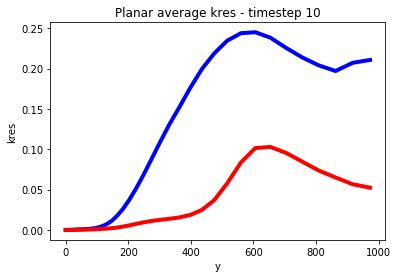

In [42]:
stepNum = 10
dnsfn = '/workspace/jmelvin/Research/channelFlow/channelFlow/dns_data/Re1000.txt'
cdpfn = '/workspace/jmelvin/Research/dataFiles/CDP-Best_52219/HYB-KEPS1000.' + str(10000+200*stepNum).zfill(6) + '.plt'
nalubn = '/workspace/jmelvin/Research/dataFiles/Nalu-Best_52219/TAMS-KEps-Re1000_52219.e'
naluNP = 32
visco = 0.000999488 # 0.000192831 
DSplotCDPvsNalu(cdpfn,nalubn,naluNP,"kres",False,visco,stepNum,False,False,dnsfn,False,100,1000,0,2)

In [3]:
def NALUprocessDS(bname,numPart,var,log,visc,ts,save):
    Retau = 1.0/visc #assumes a channel height of 1 and a utau of 1.0
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    for j in range(0,numPart):
        if (numPart > 1):
            fn = bname + "." + str(numPart) + "." + str(j).zfill(2)
            f = nc.Dataset(fn,"r")
    
            x = f['coordx']
            y = f['coordy']
            z = f['coordz']

            for i in range(0,f.dimensions["num_nod_var"].size):
                if (''.join(f["name_nod_var"][i].data) == "average_velocity_x"):
                    avgUx = f["vals_nod_var%i" % (i+1)][ts]
                if (''.join(f["name_nod_var"][i].data) == "average_velocity_y"):
                    avgUy = f["vals_nod_var%i" % (i+1)][ts]
                if (''.join(f["name_nod_var"][i].data) == "average_velocity_z"):
                    avgUz = f["vals_nod_var%i" % (i+1)][ts]
                if (''.join(f["name_nod_var"][i].data) == "velocity_x"):
                    ux = f["vals_nod_var%i" % (i+1)][ts]
                if (''.join(f["name_nod_var"][i].data) == "velocity_y"):
                    uy = f["vals_nod_var%i" % (i+1)][ts]
                if (''.join(f["name_nod_var"][i].data) == "velocity_z"):
                    uz = f["vals_nod_var%i" % (i+1)][ts]
                if (''.join(f["name_nod_var"][i].data) == "k_ratio"):
                    alpha = f["vals_nod_var%i" % (i+1)][ts]
                if (''.join(f["name_nod_var"][i].data) == "turbulent_ke"):
                    tke = f["vals_nod_var%i" % (i+1)][ts]
 
            if (j == 0):
                print f["time_whole"][ts]
                rawdata = pd.DataFrame({'x':x[:],'y':y[:],'z':z[:],'ux':ux[:],'uy':uy[:],'uz':uz[:],'avgUx':avgUx[:],'avgUy':avgUy[:],'avgUz':avgUz[:],'alpha':alpha[:],'tke':tke[:]})
            else:
                tmpdata = pd.DataFrame({'x':x[:],'y':y[:],'z':z[:],'ux':ux[:],'uy':uy[:],'uz':uz[:],'avgUx':avgUx[:],'avgUy':avgUy[:],'avgUz':avgUz[:],'alpha':alpha[:],'tke':tke[:]})
                rawdata = pd.concat([rawdata,tmpdata])
        
        else:
            fn = bname
            f = nc.Dataset(fn,"r")
    
            x = f['coordx']
            y = f['coordy']
            z = f['coordz']

            print f["time_whole"][ts]

            for i in range(0,f.dimensions["num_nod_var"].size):
                if (''.join(f["name_nod_var"][i].data) == "average_velocity_x"):
                    avgUx = f["vals_nod_var%i" % (i+1)][ts]
                if (''.join(f["name_nod_var"][i].data) == "average_velocity_y"):
                    avgUy = f["vals_nod_var%i" % (i+1)][ts]
                if (''.join(f["name_nod_var"][i].data) == "average_velocity_z"):
                    avgUz = f["vals_nod_var%i" % (i+1)][ts]
                if (''.join(f["name_nod_var"][i].data) == "velocity_x"):
                    ux = f["vals_nod_var%i" % (i+1)][ts]
                if (''.join(f["name_nod_var"][i].data) == "velocity_y"):
                    uy = f["vals_nod_var%i" % (i+1)][ts]
                if (''.join(f["name_nod_var"][i].data) == "velocity_z"):
                    uz = f["vals_nod_var%i" % (i+1)][ts]
                if (''.join(f["name_nod_var"][i].data) == "k_ratio"):
                    alpha = f["vals_nod_var%i" % (i+1)][ts]
                if (''.join(f["name_nod_var"][i].data) == "turbulent_ke"):
                    tke = f["vals_nod_var%i" % (i+1)][ts]
    
            rawdata = pd.DataFrame({'x':x[:],'y':y[:],'z':z[:],'ux':ux[:],'uy':uy[:],'uz':uz[:],'avgUx':avgUx[:],'avgUy':avgUy[:],'avgUz':avgUz[:],'alpha':alpha[:],'tke':tke[:]})

    rawdata = rawdata.round(10)
    yCoords = rawdata.y.unique()
    rawdata["fluctUx"] = rawdata["ux"] - rawdata["avgUx"]
    rawdata["fluctUy"] = rawdata["uy"] - rawdata["avgUy"]
    rawdata["fluctUz"] = rawdata["uz"] - rawdata["avgUz"]
    rawdata["varUx"] = rawdata["fluctUx"]*rawdata["fluctUx"]
    rawdata["varUy"] = rawdata["fluctUy"]*rawdata["fluctUy"]
    rawdata["varUz"] = rawdata["fluctUz"]*rawdata["fluctUz"]
    
    #print rawdata
    
    planarAvg = np.zeros((len(yCoords),12))
    index = 0
    for yc in yCoords:
      sliceY = rawdata.loc[(rawdata['y'] == yc)]
      avgUx = sliceY.ux.sum()/len(sliceY)
      avgUy = sliceY.uy.sum()/len(sliceY)
      avgUz = sliceY.uz.sum()/len(sliceY)
      avgAvgUx = sliceY.avgUx.sum()/len(sliceY)
      avgAvgUy = sliceY.avgUy.sum()/len(sliceY)
      avgAvgUz = sliceY.avgUz.sum()/len(sliceY)
      avgAlpha = sliceY.alpha.sum()/len(sliceY)
      avgTke = sliceY.tke.sum()/len(sliceY)
      uuVar = sliceY.varUx.sum()/len(sliceY)
      vvVar = sliceY.varUy.sum()/len(sliceY)
      wwVar = sliceY.varUz.sum()/len(sliceY)
      planarAvg[index] = np.array([yc/visc,avgUx,avgUy,avgUz,avgAvgUx,avgAvgUy,avgAvgUz,avgAlpha,avgTke,uuVar,vvVar,wwVar])
      index = index + 1
    
    pltFrame = pd.DataFrame(planarAvg,columns=['y','ux','uy','uz','avgUx','avgUy','avgUz','alpha','tke','uu','vv','ww'])
    
    pltFrame = pltFrame.loc[(pltFrame['y'] <= 1.0/visc)]
    pltFrame = pltFrame.sort_values(by=['y'])
    
    ax.plot(pltFrame.y,pltFrame[var])
    #ax.set_ylim(0.0,25.0)

    if (log):
        ax.set_xscale('log')
    if (save):
        plt.savefig('/workspace/jmelvin/Research/channelFlow/alphaMovies/nalu_' + str(ts).zfill(4))
        plt.close(fig)
    else:
        plt.show()
        
    return pltFrame

In [15]:
files=[]
for i in range(0, 353):
    files.append("/workspace/jmelvin/meshes/HYB-KEPS1000." + str(10000+i*50).zfill(6) + ".plt")
print files
CDPprocessDS(files,"alpha",True,0.000999488,True)

['/workspace/jmelvin/meshes/HYB-KEPS1000.010000.plt', '/workspace/jmelvin/meshes/HYB-KEPS1000.010050.plt', '/workspace/jmelvin/meshes/HYB-KEPS1000.010100.plt', '/workspace/jmelvin/meshes/HYB-KEPS1000.010150.plt', '/workspace/jmelvin/meshes/HYB-KEPS1000.010200.plt', '/workspace/jmelvin/meshes/HYB-KEPS1000.010250.plt', '/workspace/jmelvin/meshes/HYB-KEPS1000.010300.plt', '/workspace/jmelvin/meshes/HYB-KEPS1000.010350.plt', '/workspace/jmelvin/meshes/HYB-KEPS1000.010400.plt', '/workspace/jmelvin/meshes/HYB-KEPS1000.010450.plt', '/workspace/jmelvin/meshes/HYB-KEPS1000.010500.plt', '/workspace/jmelvin/meshes/HYB-KEPS1000.010550.plt', '/workspace/jmelvin/meshes/HYB-KEPS1000.010600.plt', '/workspace/jmelvin/meshes/HYB-KEPS1000.010650.plt', '/workspace/jmelvin/meshes/HYB-KEPS1000.010700.plt', '/workspace/jmelvin/meshes/HYB-KEPS1000.010750.plt', '/workspace/jmelvin/meshes/HYB-KEPS1000.010800.plt', '/workspace/jmelvin/meshes/HYB-KEPS1000.010850.plt', '/workspace/jmelvin/meshes/HYB-KEPS1000.01090

step 010050
step 010100
step 010150
step 010200
step 010250
step 010300
step 010350
step 010400
step 010450
step 010500
step 010550
step 010600
step 010650
step 010700
step 010750
step 010800
step 010850
step 010900
step 010950
step 011000
step 011050
step 011100
step 011150
step 011200
step 011250
step 011300
step 011350
step 011400
step 011450
step 011500
step 011550
step 011600
step 011650
step 011700
step 011750
step 011800
step 011850
step 011900
step 011950
step 012000
step 012050
step 012100
step 012150
step 012200
step 012250
step 012300
step 012350
step 012400
step 012450
step 012500
step 012550
step 012600
step 012650
step 012700
step 012750
step 012800
step 012850
step 012900
step 012950
step 013000
step 013050
step 013100
step 013150
step 013200
step 013250
step 013300
step 013350
step 013400
step 013450
step 013500
step 013550
step 013600
step 013650
step 013700
step 013750
step 013800
step 013850
step 013900
step 013950
step 014000
step 014050
step 014100
step 014150
step

<Figure size 432x288 with 0 Axes>

540.2999999996468


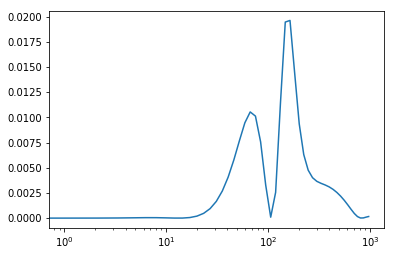

In [68]:
bn = "/workspace/jmelvin/meshes/TAMS_KE-Channel-BUGFIX.e"
naluFrame = NALUprocessDS(bn,32,"uu",True,0.000999488,15,False)

In [151]:
bn = "/workspace/jmelvin/meshes/TAMS_KE-Channel-numerics.e"
for i in range(0,550):
  NALUprocessDS(bn,32,"alpha",True,0.000999488,i,True)

539.9999999996539
540.4999999996535
540.999999999653
541.4999999996526
541.9999999996521
542.4999999996517
542.9999999996512
543.4999999996508
543.9999999996503
544.4999999996498
544.9999999996494
545.4999999996489
545.9999999996485
546.499999999648
546.9999999996476
547.4999999996471
547.9999999996467
548.4999999996462
548.9999999996458
549.4999999996453
549.9999999996448
550.4999999996444
550.9999999996439
551.4999999996435
551.999999999643
552.4999999996426
552.9999999996421
553.4999999996417
553.9999999996412
554.4999999996407
554.9999999996403
555.4999999996398
555.9999999996394
556.4999999996389
556.9999999996385
557.499999999638
557.9999999996376
558.4999999996371
558.9999999996367
559.4999999996362
559.9999999996357
560.4999999996353
560.9999999996348
561.4999999996344
561.9999999996339
562.4999999996335
562.999999999633
563.4999999996326
563.9999999996321
564.4999999996317
564.9999999996312
565.4999999996307
565.9999999996303
566.4999999996298
566.9999999996294
567.49999999962

769.4999999994452
769.9999999994448
770.4999999994443
770.9999999994438
771.4999999994434
771.9999999994429
772.4999999994425
772.999999999442
773.4999999994416
773.9999999994411
774.4999999994407
774.9999999994402
775.4999999994398
775.9999999994393
776.4999999994388
776.9999999994384
777.4999999994379
777.9999999994375
778.499999999437
778.9999999994366
779.4999999994361
779.9999999994357
780.4999999994352
780.9999999994347
781.4999999994343
781.9999999994338
782.4999999994334
782.9999999994329
783.4999999994325
783.999999999432
784.4999999994316
784.9999999994311
785.4999999994307
785.9999999994302
786.4999999994297
786.9999999994293
787.4999999994288
787.9999999994284
788.4999999994279
788.9999999994275
789.499999999427
789.9999999994266
790.4999999994261
790.9999999994257
791.4999999994252
791.9999999994247
792.4999999994243
792.9999999994238
793.4999999994234
793.9999999994229
794.4999999994225
794.999999999422
795.4999999994216
795.9999999994211
796.4999999994207
796.99999999942

In [66]:
numFrames=16
numFrames*.02 / (2.0*3.1415/20.5)

1.0440872194811397

In [ ]:
NaluForcing("/workspace/jmelvin/meshes/coriForcingField.txt",1,True)

In [3]:
def NaluResAdeq(fname):
  dfS = pd.read_table(fname, delim_whitespace=True,header=None, names=['x','y','z','maxPM','time','v2','RDij','Psgs','tau','alpha','tvisc','epsilon','Mx','My','Mz','Myz'])

  tsRows = (dfS.loc[(dfS['x'] == dfS['x'].values[0]) & (dfS['z'] == dfS['z'].values[0]) & (dfS['y'] == dfS['y'].values[0])]).index[1]
  print tsRows

  dfS['timestep'] = dfS.index/tsRows
  dfS['epsilon'] =dfS.epsilon*dfS.epsilon*dfS.epsilon

  return dfS

def NaluResAdeqPlot(df,var,ts,plotHere,save):
  zCoords = df.z.unique()
  yCoords = df.y.unique()
  xCoords = df.x.unique()
  timesteps = df.timestep.unique()

  print yCoords

  planarAvgForce = np.zeros((len(yCoords),14))
  index = 0
    
  for yc in yCoords:
  #for yc in xCoords:
      sliceY = df.loc[(df['y'] == yc) & (df['timestep'] == ts)]
      #sliceY = df.loc[(df['x'] == yc) & (df['y'] > 0.49) & (df['y'] < 0.51) & (df['timestep'] == ts)]
      maxPM = sliceY.maxPM.sum()/len(sliceY)
      time = sliceY.time.sum()/len(sliceY)
      v2 = sliceY.v2.sum()/len(sliceY)
      RDij = sliceY.RDij.sum()/len(sliceY)
      Psgs = sliceY.Psgs.sum()/len(sliceY)
      tau = sliceY.tau.sum()/len(sliceY)
      alpha = sliceY.alpha.sum()/len(sliceY)
      tvisc = sliceY.tvisc.sum()/len(sliceY)
      epsilon = sliceY.epsilon.sum()/len(sliceY)
      m11 = sliceY.Mx.sum()/len(sliceY)
      m22 = sliceY.My.sum()/len(sliceY)
      m33 = sliceY.Mz.sum()/len(sliceY)
      m23 = sliceY.Myz.sum()/len(sliceY)
      planarAvgForce[index] = np.array([yc,maxPM,time,v2,RDij,Psgs,tau,alpha,tvisc,epsilon,m11,m22,m33,m23])
      index = index + 1
  pltFrame = pd.DataFrame(planarAvgForce,columns=['y','maxPM','time','v2','RDij','Psgs','tau','alpha','tvisc','epsilon','m11','m22','m33','m23'])
  pltFrame = pltFrame.sort_values(by=['y'])

  if (plotHere):
      fig, ax = plt.subplots()
      ax.plot(pltFrame.y,pltFrame[var])
      ax.set(xlabel='y',ylabel="%s" % var,title="Planar average %s - timestep %i" % (var,ts))

      if (save):
          plt.savefig('/workspace/jmelvin/Research/channelFlow/alphaMovies/nalu_' + str(ts).zfill(4))
          plt.close(fig)
      else:
          plt.show()
        
  return pltFrame


def CDPResAdeq(basename,numProcs):
  for i in range(0,numProcs):
      fname = basename + str(i).zfill(3) + ".txt"
      tmp = pd.read_table(fname,delim_whitespace=True,header=None,names=['x','y','z','rk','maxPM','time','v2','RDij','Psgs','tau','alpha','tvisc','epsilon'])
      tsRows = (tmp.loc[(tmp['x'] == tmp['x'].values[0]) & (tmp['z'] == tmp['z'].values[0]) & (tmp['y'] == tmp['y'].values[0])]).index[1]
      tmp['timestep'] = tmp.index/tsRows
      if (i == 0):
          dfS = tmp
      else:
          dfS = pd.concat([dfS,tmp])

  return dfS

def CDPResAdeqPlot(df,var,ts,plotHere,save):
  zCoords = df.z.unique()
  yCoords = df.y.unique()
  xCoords = df.x.unique()
  timesteps = df.timestep.unique()

  planarAvgForce = np.zeros((len(yCoords),11))
  index = 0
  for yc in yCoords:
  #for yc in xCoords:
      sliceY = df.loc[(df['y'] == yc) & (df['timestep'] == ts)]
      #sliceY = df.loc[(df['x'] == yc) & (df['y'] > 0.49) & (df['y'] < 0.51) & (df['timestep'] == ts)]
      rk = sliceY.rk.sum()/len(sliceY)
      maxPM = sliceY.maxPM.sum()/len(sliceY)
      time = sliceY.time.sum()/len(sliceY)
      v2 = sliceY.v2.sum()/len(sliceY)
      RDij = sliceY.RDij.sum()/len(sliceY)
      Psgs = sliceY.Psgs.sum()/len(sliceY)
      tau = sliceY.tau.sum()/len(sliceY)
      alpha = sliceY.alpha.sum()/len(sliceY)
      tvisc = sliceY.tvisc.sum()/len(sliceY)
      epsilon = sliceY.epsilon.sum()/len(sliceY)
      planarAvgForce[index] = np.array([yc,rk,maxPM,time,v2,RDij,Psgs,tau,alpha,tvisc,epsilon])
      index = index + 1
  pltFrame = pd.DataFrame(planarAvgForce,columns=['y','rk','maxPM','time','v2','RDij','Psgs','tau','alpha','tvisc','epsilon'])
  pltFrame = pltFrame.sort_values(by=['y'])
    
  if (plotHere):
      fig, ax = plt.subplots()
      ax.plot(pltFrame.y,pltFrame[var])
      ax.set(xlabel='y',ylabel="%s" % var,title="Planar average %s - timestep %i" % (var,ts))

      plt.show()

  else:
      return pltFrame
    

def plotCDPvsNaluResAdeq(dfCDP,dfNalu,var,ts,save,xL,xH,yL,yH,customAxes):
  cdpPlot = CDPResAdeqPlot(dfCDP,var,ts,False,False)
  naluPlot = NaluResAdeqPlot(dfNalu,var,ts,False,False)
  if (var != "forcing"):
      fig, ax = plt.subplots()
      ax.plot(cdpPlot.y,cdpPlot[var],'b')
      ax.plot(naluPlot.y,naluPlot[var],'r')
      ax.set(xlabel='y',ylabel="%s" % var,title="Planar average %s - timestep %i" % (var,ts))
      if (customAxes):
        ax.set_xlim(xL,xH)
        ax.set_ylim(yL,yH)
  else:
      fig = plt.figure()
      ax1 = plt.subplot(311)
      ax1.plot(cdpPlot.y,cdpPlot['fxfx'],'b')
      ax1.plot(naluPlot.y,naluPlot['fxfx'],'r')
      ax1.set(xlabel='y',ylabel="%s" % 'fxfx',title="Planar average %s - timestep %i" % ('fxfx',ts)) 
      ax2 = plt.subplot(312)
      ax2.plot(cdpPlot.y,cdpPlot['fyfy'],'b')
      ax2.plot(naluPlot.y,naluPlot['fyfy'],'r')
      ax2.set(xlabel='y',ylabel="%s" % 'fyfy',title="Planar average %s - timestep %i" % ('fyfy',ts)) 
      ax3 = plt.subplot(313)
      ax3.plot(cdpPlot.y,cdpPlot['fzfz'],'b')
      ax3.plot(naluPlot.y,naluPlot['fzfz'],'r')
      ax3.set(xlabel='y',ylabel="%s" % 'fzfz',title="Planar average %s - timestep %i" % ('fzfz',ts)) 

  if (save):
      plt.tight_layout()
      plt.savefig('/workspace/jmelvin/Research/dataAnalysis/CDPvsNalu_' + var + "_" + str(ts).zfill(4))
      plt.close(fig)
  else:
      print "CDP - blue, Nalu - red"
      plt.show()
    
def plotNaluvsNaluResAdeq(dfNalu1,dfNalu2,var,ts,save,xL,xH,yL,yH,customAxes):
  naluPlot1 = NaluResAdeqPlot(dfNalu1,var,ts,False,False)
  naluPlot2 = NaluResAdeqPlot(dfNalu2,var,ts,False,False)
  if (var != "forcing"):
      fig, ax = plt.subplots()
      ax.plot(naluPlot1.y,naluPlot1[var],'b')
      ax.plot(naluPlot2.y,naluPlot2[var],'r')
      ax.set(xlabel='y',ylabel="%s" % var,title="Planar average %s - timestep %i" % (var,ts))
      if (customAxes):
        ax.set_xlim(xL,xH)
        ax.set_ylim(yL,yH)
        
  if (save):
      plt.tight_layout()
      plt.savefig('/workspace/jmelvin/Research/dataAnalysis/NaluvsNalu_' + var + "_" + str(ts).zfill(4))
      plt.close(fig)
  else:
      print "CDP - blue, Nalu - red"
      plt.show()

In [120]:
NaluResAdeqDF1 = NaluResAdeq("/workspace/jmelvin/Research/dataFiles/Nalu-nodalMij/resAdeq-PMelem.txt")
NaluResAdeqDF2 = NaluResAdeq("/workspace/jmelvin/Research/dataFiles/Nalu-nodalMij/resAdeq-PMnodal.txt")

161571
16209


[2.50000e-04 1.35824e+00 1.45122e+00 5.26856e-01 1.57420e+00 1.61054e+00
 1.40576e+00 6.17747e-01 8.21551e-01 1.15144e+00 8.75777e-01 7.50000e-04
 1.38225e+00 1.47314e+00 5.48778e-01 1.59266e+00 1.62783e+00 1.42876e+00
 6.41758e-01 8.48562e-01 1.17845e+00 9.03197e-01 5.00000e-04 1.37025e+00
 1.46218e+00 5.37817e-01 1.58343e+00 1.61918e+00 1.41726e+00 6.29752e-01
 8.35056e-01 1.16494e+00 8.89487e-01 1.49450e+00 1.51530e+00 1.50490e+00
 1.27880e-03 5.71240e-01 1.20518e+00 1.83640e-03 5.94241e-01 1.23163e+00
 1.55760e-03 5.82740e-01 1.21841e+00 1.64454e+00 9.30742e-01 1.66067e+00
 9.58412e-01 1.65260e+00 9.44577e-01 1.53551e+00 2.42609e-03 1.55515e+00
 3.04785e-03 1.54533e+00 2.73697e-03 6.66231e-01 6.91167e-01 6.78699e-01
 1.25773e+00 1.28349e+00 1.27061e+00 1.67623e+00 9.86123e-01 1.69123e+00
 1.01388e+00 1.68373e+00 1.00000e+00 3.70534e-03 4.39856e-03 4.05195e-03
 1.30883e+00 1.33377e+00 1.32130e+00 5.13155e-03 1.70567e+00 1.04159e+00
 5.90431e-03 1.71957e+00 1.06926e+00 5.51793e-03 1.

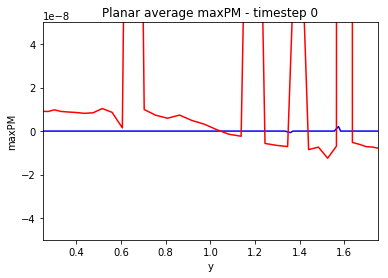

In [127]:
plotNaluvsNaluResAdeq(NaluResAdeqDF1,NaluResAdeqDF2,"maxPM",0,False,0.25,1.75,-0.00000005,0.00000005,True)

CDP - blue, Nalu - red


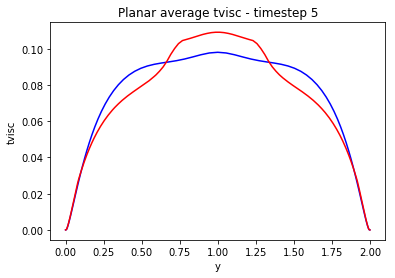

In [118]:
plotCDPvsNaluResAdeq(cdpResAdeqDF,NaluResAdeqDF,"tvisc",5,False,0.00,2.00,.005,2.002,False)

CDP - blue, Nalu - red


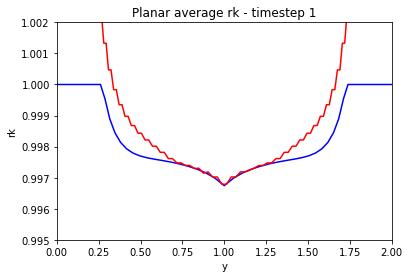

In [99]:
plotCDPvsNalu(cdpForceDF,NaluForceDF,"rk",1,False,0.00,2.00,1-.005,1.002,True)

In [69]:
def NaluTDRSource(fname):
  dfS = pd.read_table(fname, delimiter='\[|,|\]\[|\]', engine='python', header=None, names=['trash1','x1','x2','x3','x4','y1','y2','y3','y4','z1','z2','z3','z4','Pk1','Pk2','Pk3','Pk4','Pe1','Pe2','Pe3','Pe4','De1','De2','De3','De4','Le1','Le2','Le3','Le4','tke1','tke2','tke3','tke4','tdr1','tdr2','tdr3','tdr4','Ret1','Ret2','Ret3','Ret4','fe21','fe22','fe23','fe24','time1','time2','time3','time4','trash2'])
    
  del dfS['trash1']
  del dfS['trash2']

  #tsRows = (dfS.loc[(dfS['x1'] == dfS['x1'].values[0]) & (dfS['z1'] == dfS['z1'].values[0]) & (dfS['y1'] == dfS['y1'].values[0])]).index[1]
  #print tsRows

  #dfS['timestep'] = dfS.index/tsRows

  tmp1 = dfS.loc[:,['x1','y1','z1','Pk1','Pe1','De1','Le1','tke1','tdr1','Ret1','fe21','time1']]
  tmp2 = dfS.loc[:,['x2','y2','z2','Pk2','Pe2','De2','Le2','tke2','tdr2','Ret2','fe22','time2']]
  tmp3 = dfS.loc[:,['x3','y3','z3','Pk3','Pe3','De3','Le3','tke3','tdr3','Ret3','fe23','time3']]
  tmp4 = dfS.loc[:,['x4','y4','z4','Pk4','Pe4','De4','Le4','tke4','tdr4','Ret4','fe24','time4']]
  tmp1.columns = ['x','y','z','Pk','Pe','De','Le','tke','tdr','Ret','fe2','time']
  tmp2.columns = ['x','y','z','Pk','Pe','De','Le','tke','tdr','Ret','fe2','time']
  tmp3.columns = ['x','y','z','Pk','Pe','De','Le','tke','tdr','Ret','fe2','time']
  tmp4.columns = ['x','y','z','Pk','Pe','De','Le','tke','tdr','Ret','fe2','time']
  dfS = pd.concat([tmp1,tmp2,tmp3,tmp4])

  return dfS

def NaluTDRSourcePlot(df,var,ts,plotHere,save):
  zCoords = df.z.unique()
  yCoords = df.y.unique()
  xCoords = df.x.unique()

  planarAvgForce = np.zeros((len(yCoords),10))
  index = 0
  for yc in yCoords:
  #for yc in xCoords:
      sliceY = df.loc[(df['y'] == yc)]
      #sliceY = df.loc[(df['x'] == yc) & (df['y'] > 0.49) & (df['y'] < 0.51) & (df['timestep'] == ts)]
      Pe = sliceY.Pe.sum()/len(sliceY)
      De = sliceY.De.sum()/len(sliceY)
      Le = sliceY.Le.sum()/len(sliceY)
      Pk = sliceY.Pk.sum()/len(sliceY)
      Ret = sliceY.Ret.sum()/len(sliceY)
      fe2 = sliceY.fe2.sum()/len(sliceY)
      tke = sliceY.tke.sum()/len(sliceY)
      tdr = sliceY.tdr.sum()/len(sliceY)
      time = sliceY.time.sum()/len(sliceY)
      planarAvgForce[index] = np.array([yc,Pk,Pe,De,Le,Ret,fe2,tke,tdr,time])
      index = index + 1
  pltFrame = pd.DataFrame(planarAvgForce,columns=['y','Pk','Pe','De','Le','Ret','fe2','tke','tdr','time'])
  pltFrame = pltFrame.sort_values(by=['y'])

  if (plotHere):
      fig, ax = plt.subplots()
      ax.plot(pltFrame.y,pltFrame[var])
      ax.set(xlabel='y',ylabel="%s" % var,title="Planar average %s - timestep %i" % (var,ts))

      if (save):
          plt.savefig('/workspace/jmelvin/Research/channelFlow/alphaMovies/nalu_' + str(ts).zfill(4))
          plt.close(fig)
      else:
          plt.show()
        
  return pltFrame


def CDPTDRSource(basename,numProcs):
  for i in range(0,numProcs):
      fname = basename + str(i).zfill(3) + ".txt"
      #tmp = pd.read_table(fname,delim_whitespace=True,header=None,names=['x','y','z','forceX','forceY','forceZ','norm','v2','alpha','tke','tdr','rk','ux','uy','uz'])
      tmp = pd.read_table(fname,delim_whitespace=True,header=None,names=['x','y','z','Pk','Pe','De','Le','tke','tdr','Ret','fe2','time'])
      if (i == 0):
          dfS = tmp
      else:
          dfS = pd.concat([dfS,tmp])
  
  return dfS

def CDPTDRSourcePlot(df,var,ts,plotHere,save):
  zCoords = df.z.unique()
  yCoords = df.y.unique()
  xCoords = df.x.unique()

  planarAvgForce = np.zeros((len(yCoords),10))
  index = 0
  for yc in yCoords:
  #for yc in xCoords:
      sliceY = df.loc[(df['y'] == yc)]
      #sliceY = df.loc[(df['x'] == yc) & (df['y'] > 0.49) & (df['y'] < 0.51) & (df['timestep'] == ts)]
      Pe = sliceY.Pe.sum()/len(sliceY)
      De = sliceY.De.sum()/len(sliceY)
      Le = sliceY.Le.sum()/len(sliceY)
      Pk = sliceY.Pk.sum()/len(sliceY)
      Ret = sliceY.Ret.sum()/len(sliceY)
      fe2 = sliceY.fe2.sum()/len(sliceY)
      tke = sliceY.tke.sum()/len(sliceY)
      tdr = sliceY.tdr.sum()/len(sliceY)
      time = sliceY.time.sum()/len(sliceY)
      planarAvgForce[index] = np.array([yc,Pk,Pe,De,Le,Ret,fe2,tke,tdr,time])
      index = index + 1
  pltFrame = pd.DataFrame(planarAvgForce,columns=['y','Pk','Pe','De','Le','Ret','fe2','tke','tdr','time'])
  pltFrame = pltFrame.sort_values(by=['y'])
    
  if (plotHere):
      fig, ax = plt.subplots()
      ax.plot(pltFrame.y,pltFrame[var])
      ax.set(xlabel='y',ylabel="%s" % var,title="Planar average %s - timestep %i" % (var,ts))

      plt.show()

  else:
      return pltFrame


def plotCDPvsNaluTDRSource(dfCDP,dfNalu,var,ts,save,xL,xH,yL,yH,customAxes,log):
  cdpPlot = CDPTDRSourcePlot(dfCDP,var,ts,False,False)
  naluPlot = NaluTDRSourcePlot(dfNalu,var,ts,False,False)
  if (var != "forcing"):
      fig, ax = plt.subplots()
      ax.plot(cdpPlot.y,cdpPlot[var],'b')
      ax.plot(naluPlot.y,naluPlot[var],'r')
      ax.set(xlabel='y',ylabel="%s" % var,title="Planar average %s - timestep %i" % (var,ts))
      if (customAxes):
        ax.set_xlim(xL,xH)
        ax.set_ylim(yL,yH)
      if (log):
        ax.set_yscale('log')
  else:
      fig = plt.figure()
      ax1 = plt.subplot(311)
      ax1.plot(cdpPlot.y,cdpPlot['fxfx'],'b')
      ax1.plot(naluPlot.y,naluPlot['fxfx'],'r')
      ax1.set(xlabel='y',ylabel="%s" % 'fxfx',title="Planar average %s - timestep %i" % ('fxfx',ts)) 
      ax2 = plt.subplot(312)
      ax2.plot(cdpPlot.y,cdpPlot['fyfy'],'b')
      ax2.plot(naluPlot.y,naluPlot['fyfy'],'r')
      ax2.set(xlabel='y',ylabel="%s" % 'fyfy',title="Planar average %s - timestep %i" % ('fyfy',ts)) 
      ax3 = plt.subplot(313)
      ax3.plot(cdpPlot.y,cdpPlot['fzfz'],'b')
      ax3.plot(naluPlot.y,naluPlot['fzfz'],'r')
      ax3.set(xlabel='y',ylabel="%s" % 'fzfz',title="Planar average %s - timestep %i" % ('fzfz',ts)) 
            
  if (save):
      plt.tight_layout()
      plt.savefig('/workspace/jmelvin/Research/dataAnalysis/CDPvsNalu_' + var + "_" + str(ts).zfill(4))
      plt.close(fig)
  else:
      print "CDP - blue, Nalu - red"
      plt.show()

In [47]:
cdpTDRSourceDF = CDPTDRSource("/workspace/jmelvin/Research/dataFiles/Nalu-debug-TDR/cdp-tdrSource",96)
NaluTDRSourceDF = NaluTDRSource("/workspace/jmelvin/Research/dataFiles/Nalu-debug-TDR/tdrSource.txt")

/h1/jmelvin/.local/lib/python2.7/site-packages/ipykernel_launcher.py:67: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
/h1/jmelvin/.local/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: read_table is deprecated, use read_csv instead.
  


CDP - blue, Nalu - red


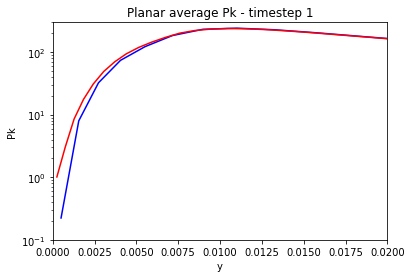

In [74]:
plotCDPvsNaluTDRSource(cdpTDRSourceDF,NaluTDRSourceDF,"Pk",1,False,0.00,0.02,0.1,300,True,True)

In [49]:
NaluTDRSourceDF

,x,y,z,Pk,Pe,De,Le,tke,tdr,Ret,fe2,time
0,0.277199,0.000250,0.098175,1.011780,60.853400,69.88810,-3.162160e+04,0.011022,1.120390,0.108488,0.77785,0.022446
1,6.190790,1.610540,0.098175,4.356880,15.399900,20.93300,-1.424650e-86,2.041330,4.441720,938.635000,1.00000,0.381937
2,5.451590,0.000250,1.668970,1.011780,60.853300,69.88790,-3.162150e+04,0.011022,1.120390,0.108488,0.77785,0.022446
3,4.712390,0.000250,1.668970,1.011780,60.853300,69.88790,-3.162160e+04,0.011022,1.120390,0.108488,0.77785,0.022446
4,2.864390,0.000250,0.098175,1.011780,60.853300,69.88800,-3.162160e+04,0.011022,1.120390,0.108488,0.77785,0.022446
5,1.386000,1.451220,0.883573,2.193370,5.322270,7.91034,-9.629310e-122,1.570560,2.444960,1009.390000,1.00000,0.556351
6,2.125200,1.151440,2.061670,0.238591,0.293835,1.46545,-1.088430e-187,0.976210,0.892446,1068.380000,1.00000,1.096190
7,5.081990,0.821551,2.061670,0.330817,0.423633,1.63640,-9.208260e-182,1.008290,0.958403,1061.330000,1.00000,1.054220
8,4.712390,1.574200,1.276270,3.748050,12.160300,16.69670,-1.319100e-94,1.926190,3.859690,961.767000,1.00000,0.416096
9,6.190790,0.000250,0.490874,1.011780,60.853300,69.88800,-3.162160e+04,0.011022,1.120390,0.108488,0.77785,0.022446


In [73]:
def debugNaluResAdeq(fname):
  dfS = pd.read_table(fname, delim_whitespace=True,header=None, 
              names=['x','y','z',
                     'dudx11','dudx12','dudx13',
                     'dudx21','dudx22','dudx23',
                     'dudx31','dudx32','dudx33',
                     'avgDudx11','avgDudx12','avgDudx13',
                     'avgDudx21','avgDudx22','avgDudx23',
                     'avgDudx31','avgDudx32','avgDudx33'])

  tsRows = (dfS.loc[(dfS['x'] == dfS['x'].values[0]) & 
                    (dfS['z'] == dfS['z'].values[0]) & 
                    (dfS['y'] == dfS['y'].values[0])]).index[1]
  print tsRows

  dfS['timestep'] = dfS.index/tsRows

  return dfS

def debugNaluResAdeqPlot(df,var,ts,plotHere,save):
  zCoords = df.z.unique()
  yCoords = df.y.unique()
  xCoords = df.x.unique()
  timesteps = df.timestep.unique()

  #print yCoords

  planarAvgForce = np.zeros((len(yCoords),19))
  index = 0
    
  #for yc in yCoords:
  for yc in xCoords:
      #sliceY = df.loc[(df['y'] == yc) & (df['timestep'] == ts)]
      sliceY = df.loc[(df['x'] == yc) & (df['y'] > 0.95) & (df['y'] < 0.98) & (df['timestep'] == ts)]
      dudx11 = sliceY.dudx11.sum()/len(sliceY)
      dudx12 = sliceY.dudx12.sum()/len(sliceY)
      dudx13 = sliceY.dudx13.sum()/len(sliceY)
      dudx21 = sliceY.dudx21.sum()/len(sliceY)
      dudx22 = sliceY.dudx22.sum()/len(sliceY)
      dudx23 = sliceY.dudx23.sum()/len(sliceY)
      dudx31 = sliceY.dudx31.sum()/len(sliceY)
      dudx32 = sliceY.dudx32.sum()/len(sliceY)
      dudx33 = sliceY.dudx33.sum()/len(sliceY)
      avgDudx11 = sliceY.avgDudx11.sum()/len(sliceY)
      avgDudx12 = sliceY.avgDudx12.sum()/len(sliceY)
      avgDudx13 = sliceY.avgDudx13.sum()/len(sliceY)
      avgDudx21 = sliceY.avgDudx21.sum()/len(sliceY)
      avgDudx22 = sliceY.avgDudx22.sum()/len(sliceY)
      avgDudx23 = sliceY.avgDudx23.sum()/len(sliceY)
      avgDudx31 = sliceY.avgDudx31.sum()/len(sliceY)
      avgDudx32 = sliceY.avgDudx32.sum()/len(sliceY)
      avgDudx33 = sliceY.avgDudx33.sum()/len(sliceY)
      planarAvgForce[index] = np.array([yc,
                                        dudx11,dudx12,dudx13,
                                        dudx21,dudx22,dudx23,
                                        dudx31,dudx32,dudx33,
                                        avgDudx11,avgDudx12,avgDudx13,
                                        avgDudx21,avgDudx22,avgDudx23,
                                        avgDudx31,avgDudx32,avgDudx33])
      index = index + 1
  pltFrame = pd.DataFrame(planarAvgForce,columns=['y',
                     'dudx11','dudx12','dudx13',
                     'dudx21','dudx22','dudx23',
                     'dudx31','dudx32','dudx33',
                     'avgDudx11','avgDudx12','avgDudx13',
                     'avgDudx21','avgDudx22','avgDudx23',
                     'avgDudx31','avgDudx32','avgDudx33'])
  pltFrame = pltFrame.sort_values(by=['y'])

  if (plotHere):
      fig, ax = plt.subplots()
      ax.plot(pltFrame.y,pltFrame[var])
      ax.set(xlabel='y',ylabel="%s" % var,title="Planar average %s - timestep %i" % (var,ts))

      if (save):
          plt.savefig('/workspace/jmelvin/Research/channelFlow/alphaMovies/nalu_' + str(ts).zfill(4))
          plt.close(fig)
      else:
          plt.show()
        
  return pltFrame
    
def debugPlotNaluvsNaluResAdeq(dfNalu1,dfNalu2,var,ts,save,xL,xH,yL,yH,customAxes):
  naluPlot1 = debugNaluResAdeqPlot(dfNalu1,var,ts,False,False)
  naluPlot2 = debugNaluResAdeqPlot(dfNalu2,var,ts,False,False)
  if (var != "forcing"):
      fig, ax = plt.subplots()
      ax.plot(naluPlot1.y,naluPlot1[var],'b')
      ax.plot(naluPlot2.y,naluPlot2[var],'r')
      ax.set(xlabel='y',ylabel="%s" % var,title="Planar average %s - timestep %i" % (var,ts))
      if (customAxes):
        ax.set_xlim(xL,xH)
        ax.set_ylim(yL,yH)
        
  if (save):
      plt.tight_layout()
      plt.savefig('/workspace/jmelvin/Research/dataAnalysis/NaluvsNalu_' + var + "_" + str(ts).zfill(4))
      plt.close(fig)
  else:
      print "CDP - blue, Nalu - red"
      plt.show()

In [70]:
NaluResAdeqDF1 = debugNaluResAdeq("/workspace/jmelvin/Research/dataFiles/Nalu-nodalMij/resAdeq-wtfElem.txt")
NaluResAdeqDF2 = debugNaluResAdeq("/workspace/jmelvin/Research/dataFiles/Nalu-nodalMij/resAdeq-wtfNode.txt")

13500
16226


CDP - blue, Nalu - red


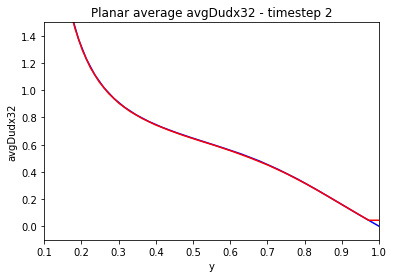

In [93]:
debugPlotNaluvsNaluResAdeq(NaluResAdeqDF1,NaluResAdeqDF2,"avgDudx32",2,False,0.1,1.0,-0.1,1.5,True)

In [59]:
NaluResAdeqDF = debugNaluResAdeq("/workspace/jmelvin/Research/dataFiles/Nalu-nodalMij/resAdeq.txt")

16224


CDP - blue, Nalu - red


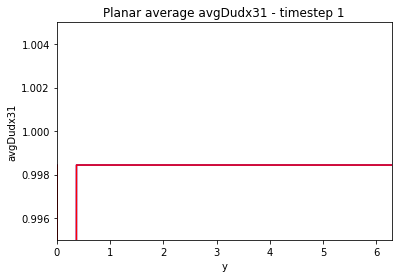

In [74]:
debugPlotNaluvsNaluResAdeq(NaluResAdeqDF,NaluResAdeqDF,"avgDudx31",1,False,0.0,6.29,0.995,1.005,True)

In [96]:
NaluForceDF.loc[(NaluForceDF['timestep'] == 0) & (NaluForceDF['y'] == 0.617747) & (NaluForceDF['z'] > 0.687222) & (NaluForceDF['z'] < 0.687224) ]

,x,y,z,forceX,forceY,forceZ,norm,alpha,v2,tke,tdr,rk,ux,uy,uz,timestep,fxfx,fyfy,fzfz
90,3.788390,0.617747,0.687223,0.000228,-0.000008,-0.000015,0.000716,8.22879,1,0,-0.000087,0.999826,-0.000087,0.072193,-0.000087,0,5.190560e-08,6.262712e-11,2.385913e-10
126,3.973190,0.617747,0.687223,0.000073,-0.000006,-0.000013,0.000239,8.22879,1,0,-0.000029,0.999942,-0.000029,0.024064,-0.000029,0,5.311203e-09,4.125853e-11,1.571964e-10
2112,5.636390,0.617747,0.687223,-0.000632,-0.000406,-0.000795,0.005028,8.22879,1,0,-0.000611,0.998779,-0.000611,0.550972,-0.000611,0,3.998766e-07,1.648863e-07,6.316848e-07
2148,5.821190,0.617747,0.687223,-0.000894,-0.000367,-0.000719,0.005028,8.22879,1,0,-0.000611,0.998779,-0.000611,0.550972,-0.000611,0,7.994398e-07,1.347778e-07,5.169524e-07
19094,2.309990,0.617747,0.687223,0.000087,0.000108,0.000211,0.001256,8.22879,1,0,-0.000153,0.999695,-0.000153,0.137743,-0.000153,0,7.605340e-09,1.165191e-08,4.440460e-08
19130,2.494790,0.617747,0.687223,0.000474,0.000305,0.000596,0.003770,8.22879,1,0,-0.000458,0.999084,-0.000458,0.413229,-0.000458,0,2.248192e-07,9.322274e-08,3.551147e-07
20034,0.831598,0.617747,0.687223,-0.000384,0.000034,0.000066,0.001256,8.22879,1,0,-0.000153,0.999695,-0.000153,0.137743,-0.000153,0,1.470784e-07,1.136897e-09,4.353585e-09
20070,1.016400,0.617747,0.687223,-0.001064,0.000157,0.000308,0.003770,8.22879,1,0,-0.000458,0.999084,-0.000458,0.413229,-0.000458,0,1.131139e-06,2.480436e-08,9.486646e-08
20843,1.940400,0.617747,0.687223,-0.000243,0.000437,0.000854,0.005028,8.22879,1,0,-0.000611,0.998779,-0.000611,0.550972,-0.000611,0,5.909372e-08,1.912986e-07,7.294817e-07
20879,2.125200,0.617747,0.687223,0.000054,0.000442,0.000863,0.005028,8.22879,1,0,-0.000611,0.998779,-0.000611,0.550972,-0.000611,0,2.906407e-09,1.955851e-07,7.456167e-07


In [106]:
NaluResAdeqDF.loc[(NaluResAdeqDF['timestep'] == 0) & (NaluResAdeqDF['y'] >= 0.605741) & (NaluResAdeqDF['y'] <= 0.653764) & (NaluResAdeqDF['z'] >= 0.392698) & (NaluResAdeqDF['z'] <= 0.785398) ]

,x,y,z,dudx11,dudx12,dudx13,dudx21,dudx22,dudx23,dudx31,...,avgDudx11,avgDudx12,avgDudx13,avgDudx21,avgDudx22,avgDudx23,avgDudx31,avgDudx32,avgDudx33,timestep
17,3.695990,0.653764,0.785398,0.092588,1,1.30901,1.66470,1,0.786332,0.369599,...,0.265241,0.017913,0.287572,0,0.513375,9.087680e-10,1.000000,0.513375,0.998762,0
53,3.326390,0.653764,0.785398,0.092588,1,1.30901,1.66470,1,0.786332,0.369599,...,0.265241,0.017913,0.287572,0,0.513375,-2.149140e-08,1.000000,0.513375,0.998762,0
58,5.913590,0.605741,0.392699,0.091892,1,1.42284,1.98093,1,0.718270,0.369599,...,0.265241,0.016978,0.287572,0,0.563504,1.038480e-07,1.000000,0.563504,0.998785,0
94,5.543990,0.605741,0.392699,0.091892,1,1.42284,1.98093,1,0.718270,0.369599,...,0.265241,0.016978,0.287572,0,0.563504,4.933600e-08,1.000000,0.563504,0.998785,0
130,5.174390,0.605741,0.392699,0.091892,1,1.42284,1.98093,1,0.718270,0.369599,...,0.265241,0.016978,0.287572,0,0.563504,5.784760e-08,1.000000,0.563504,0.998785,0
166,5.913590,0.605741,0.785398,0.091892,1,1.42284,1.98093,1,0.718270,0.369599,...,0.265241,0.016978,0.287572,0,0.563504,1.791490e-07,1.000000,0.563504,0.998785,0
202,5.543990,0.605741,0.785398,0.091892,1,1.42284,1.98093,1,0.718270,0.369599,...,0.265241,0.016978,0.287572,0,0.563504,9.877530e-08,1.000000,0.563504,0.998785,0
238,5.174390,0.605741,0.785398,0.091892,1,1.42284,1.98093,1,0.718270,0.369599,...,0.265241,0.016978,0.287572,0,0.563504,8.416920e-08,1.000000,0.563504,0.998785,0
382,5.913590,0.653764,0.392699,0.092588,1,1.30901,1.66470,1,0.786332,0.369599,...,0.265241,0.017913,0.287572,0,0.513374,8.596920e-08,1.000000,0.513374,0.998762,0
418,5.543990,0.653764,0.392699,0.092588,1,1.30901,1.66470,1,0.786332,0.369599,...,0.265241,0.017913,0.287572,0,0.513374,4.140980e-08,1.000000,0.513374,0.998762,0


In [108]:
(NaluResAdeqDF.loc[(NaluResAdeqDF['x'] == NaluResAdeqDF['x'].values[0]) & 
                    (NaluResAdeqDF['z'] == NaluResAdeqDF['z'].values[0]) & 
                    (NaluResAdeqDF['y'] == NaluResAdeqDF['y'].values[0])])

,x,y,z,dudx11,dudx12,dudx13,dudx21,dudx22,dudx23,dudx31,...,avgDudx11,avgDudx12,avgDudx13,avgDudx21,avgDudx22,avgDudx23,avgDudx31,avgDudx32,avgDudx33,timestep
0,2.95679,1.44026,0.392699,0.091042,1,1.54070,2.34283,1,0.657623,0.369599,...,0.265241,0.015982,0.287572,0,0.607596,-1.440100e-08,1.000000,0.607596,0.998807,0
16224,2.95679,1.44026,0.392699,0.081550,1,1.59005,2.34065,1,0.570774,0.369599,...,0.265241,0.015982,0.287572,0,0.591153,2.703220e-06,0.998807,0.591153,0.997378,1
32426,2.95679,1.44026,0.392699,0.081227,1,1.58376,2.34167,1,0.570774,0.369599,...,0.265241,0.015982,0.287572,0,0.592265,2.098820e-06,0.997378,0.592265,0.995959,1
48624,2.95679,1.44026,0.392699,0.081267,1,1.58454,2.34123,1,0.570773,0.369599,...,0.265241,0.015982,0.287572,0,0.592135,2.666990e-06,0.995959,0.592135,0.994544,2
64822,2.95679,1.44026,0.392699,0.081262,1,1.58445,2.34141,1,0.570772,0.369599,...,0.265241,0.015982,0.287572,0,0.592152,3.032140e-06,0.994544,0.592152,0.993134,3
81023,2.95679,1.44026,0.392699,0.082105,1,1.60089,2.33911,1,0.570772,0.369599,...,0.265241,0.015982,0.287572,0,0.589372,6.089330e-06,0.993134,0.589372,0.991719,4
97224,2.95679,1.44026,0.392699,0.081985,1,1.59854,2.34010,1,0.570770,0.369599,...,0.265241,0.015982,0.287572,0,0.589747,6.652230e-06,0.991719,0.589747,0.990310,5
113425,2.95679,1.44026,0.392699,0.082002,1,1.59887,2.33968,1,0.570769,0.369599,...,0.265241,0.015982,0.287572,0,0.589701,7.073100e-06,0.990310,0.589701,0.988907,6
129624,2.95679,1.44026,0.392699,0.081999,1,1.59882,2.33985,1,0.570768,0.369599,...,0.265241,0.015982,0.287572,0,0.589709,7.570470e-06,0.988907,0.589709,0.987508,7
145824,2.95679,1.44026,0.392699,0.082268,1,1.60406,2.33752,1,0.570766,0.369599,...,0.265241,0.015982,0.287572,0,0.589030,1.389420e-05,0.987508,0.589030,0.986111,8


step 150000


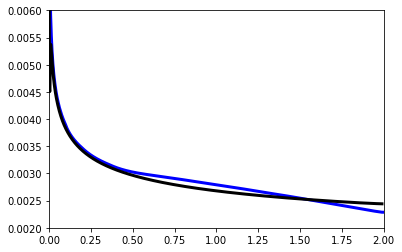

In [60]:
fname = "/workspace/jmelvin/Research/dataFiles/cdp-FlatPlate/WHUMP-FPLATE-SST.150000.plt"
visc = .000015684 * 1.177
dynPress = 0.5 * 1.177 * 78.4197 * 78.4197

dset = tec.data.load_tecplot(fname,read_data_option=tec.constant.ReadDataOption.Replace)
zone = dset.zone_names[0]
print zone
x = dset.variable('X').values(zone)
y = dset.variable('Y').values(zone)
z = dset.variable('Z').values(zone)
ux = dset.variable('U-X').values(zone)
uy = dset.variable('U-Y').values(zone)
uz = dset.variable('U-Z').values(zone)
    
rawdata = pd.DataFrame({'x':x[:],'y':y[:],'z':z[:],'ux':ux[:],'uy':uy[:],'uz':uz[:]})
rawdata = rawdata.round(10)

rawdata = rawdata.loc[(rawdata['z'] == .0000005)]
rawdata["cf"] = (visc * rawdata["ux"]/.0000005)/dynPress

xCoords = rawdata.x.unique()
    
planarAvg = np.zeros((len(xCoords),5))
index = 0
for xc in xCoords:
    sliceX = rawdata.loc[(rawdata['x'] == xc)]
    avgUx = sliceX.ux.sum()/len(sliceX)
    avgUy = sliceX.uy.sum()/len(sliceX)
    avgUz = sliceX.uz.sum()/len(sliceX)
    avgCf = sliceX.cf.sum()/len(sliceX)
    planarAvg[index] = np.array([xc,avgUx,avgUy,avgUz,avgCf])
    index = index + 1
    
pltFrame = pd.DataFrame(planarAvg,columns=['x','ux','uy','uz','cf'])
  
pltFrame = pltFrame.sort_values(by=['x'])

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(pltFrame.x,pltFrame['cf'],'b',linewidth=3)
CFL3Ddata = pd.read_csv("~/Desktop/flatPlate_cf_nasa.dat")
Naludata = pd.read_csv("~/Downloads/wall_vars (4).dat")
ax.plot(CFL3Ddata['x'],CFL3Ddata['cf'],'k',linewidth=3)
#ax.plot(Naludata['x'],Naludata['cf'],'r',linewidth=3)
ax.set_xlim(0,2)
ax.set_ylim(0.002,0.006)

plt.show()



In [19]:
CFL3Ddata = pd.read_csv("~/Desktop/cf_cfl3d.dat")

In [20]:
CFL3Ddata

,x,cf
0,-6.193347,0.005762
1,-6.009354,0.003873
2,-5.836684,0.003796
3,-5.674180,0.003641
4,-5.520834,0.003511
5,-5.375766,0.003416
6,-5.238202,0.003344
7,-5.107458,0.003287
8,-4.982929,0.003240
9,-4.864077,0.003200


In [18]:
aaa = [1,3,5]
bbb = [2,4,6]

for (a, b) in zip(aaa,bbb):
    print a, b

1 2
3 4
5 6


In [4]:
def CDPProc(fname):
  dset = tec.data.load_tecplot(fname,read_data_option=tec.constant.ReadDataOption.Replace)
  zone = dset.zone_names[0]
  print zone
  x = dset.variable('X').values(zone)
  y = dset.variable('Y').values(zone)
  z = dset.variable('Z').values(zone)
  ux = dset.variable('U-X').values(zone)
  uy = dset.variable('U-Y').values(zone)
  uz = dset.variable('U-Z').values(zone)
  tke = dset.variable('TKE').values(zone)
  sdr = dset.variable('SDR').values(zone)
    
  rawdata = pd.DataFrame({'x':x[:],'y':y[:],'z':z[:],
                          'ux':ux[:],'uy':uy[:],'uz':uz[:],
                          'tke':tke[:],'sdr':sdr[:]})
  rawdata = rawdata.round(10)

  return rawdata

def binCDP(rdata,visc):
  Retau = 1.0/visc
  yCoords = rdata.y.unique()
    
  planarAvg = np.zeros((len(yCoords),6))
  index = 0
  for yc in yCoords:
    sliceY = rdata.loc[(rdata['y'] == yc)]
    avgUx = sliceY.ux.sum()/len(sliceY)
    avgUy = sliceY.uy.sum()/len(sliceY)
    avgUz = sliceY.uz.sum()/len(sliceY)
    avgTke = sliceY.tke.sum()/len(sliceY)
    avgSdr = sliceY.sdr.sum()/len(sliceY)
    planarAvg[index] = np.array([yc/visc,avgUx,avgUy,avgUz,avgTke,avgSdr])
    index = index + 1
    
  pltFrame = pd.DataFrame(planarAvg,columns=['y','ux','uy','uz','tke','sdr'])
  pltFrame = pltFrame.loc[(pltFrame['y'] <= 1.0/visc)]
  pltFrame = pltFrame.sort_values(by=['y'])

  return pltFrame

def NaluProc(bname,numPart,ts):
    print bname, numPart, ts
    for j in range(0,numPart):
        if (numPart > 1):
            fn = bname + "." + str(numPart) + "." + str(j).zfill(1)
            if (numPart >= 10):
                fn = bname + "." + str(numPart) + "." + str(j).zfill(2)
            if (numPart >= 100):
                fn = bname + "." + str(numPart) + "." + str(j).zfill(3)
            if (numPart >= 1000):
                fn = bname + "." + str(numPart) + "." + str(j).zfill(4)
            f = nc.Dataset(fn,"r")
    
            x = f['coordx']
            y = f['coordy']
            z = f['coordz']

            for i in range(0,f.dimensions["num_nod_var"].size):
                if (''.join(f["name_nod_var"][i].data) == "velocity_x"):
                    ux = f["vals_nod_var%i" % (i+1)][ts]
                if (''.join(f["name_nod_var"][i].data) == "velocity_y"):
                    uy = f["vals_nod_var%i" % (i+1)][ts]
                if (''.join(f["name_nod_var"][i].data) == "velocity_z"):
                    uz = f["vals_nod_var%i" % (i+1)][ts]
                if (''.join(f["name_nod_var"][i].data) == "turbulent_ke"):
                    tke = f["vals_nod_var%i" % (i+1)][ts]
                if (''.join(f["name_nod_var"][i].data) == "specific_dissipation_rate"):
                    sdr = f["vals_nod_var%i" % (i+1)][ts]
 
            if (j == 0):
                print f["time_whole"][ts]
                rawdata = pd.DataFrame({'x':x[:],'y':y[:],'z':z[:],'ux':ux[:],'uy':uy[:],'uz':uz[:],
                                        'tke':tke[:],'sdr':sdr[:]})
            else:
                tmpdata = pd.DataFrame({'x':x[:],'y':y[:],'z':z[:],'ux':ux[:],'uy':uy[:],'uz':uz[:],
                                        'tke':tke[:],'sdr':sdr[:]})
                rawdata = pd.concat([rawdata,tmpdata])
        
        else:
            fn = bname
            f = nc.Dataset(fn,"r")
    
            x = f['coordx']
            y = f['coordy']
            z = f['coordz']

            print f["time_whole"][ts]

            for i in range(0,f.dimensions["num_nod_var"].size):
                if (''.join(f["name_nod_var"][i].data) == "velocity_x"):
                    ux = f["vals_nod_var%i" % (i+1)][ts]
                if (''.join(f["name_nod_var"][i].data) == "velocity_y"):
                    uy = f["vals_nod_var%i" % (i+1)][ts]
                if (''.join(f["name_nod_var"][i].data) == "velocity_z"):
                    uz = f["vals_nod_var%i" % (i+1)][ts]
                if (''.join(f["name_nod_var"][i].data) == "turbulent_ke"):
                    tke = f["vals_nod_var%i" % (i+1)][ts]
                if (''.join(f["name_nod_var"][i].data) == "specific_dissipation_rate"):
                    sdr = f["vals_nod_var%i" % (i+1)][ts]
 
            rawdata = pd.DataFrame({'x':x[:],'y':y[:],'z':z[:],'ux':ux[:],'uy':uy[:],'uz':uz[:],
                                        'tke':tke[:],'sdr':sdr[:]})

    rawdata = rawdata.round(10)
    
    return rawdata

def binNalu(rdata,visc):
  Retau = 1.0/visc
  yCoords = rdata.y.unique()
    
  planarAvg = np.zeros((len(yCoords),6))
  index = 0
  for yc in yCoords:
    sliceY = rdata.loc[(rdata['y'] == yc)]
    avgUx = sliceY.ux.sum()/len(sliceY)
    avgUy = sliceY.uy.sum()/len(sliceY)
    avgUz = sliceY.uz.sum()/len(sliceY)
    avgTke = sliceY.tke.sum()/len(sliceY)
    avgSdr = sliceY.sdr.sum()/len(sliceY)
    planarAvg[index] = np.array([yc/visc,avgUx,avgUy,avgUz,avgTke,avgSdr])
    index = index + 1
    
  pltFrame = pd.DataFrame(planarAvg,columns=['y','ux','uy','uz','tke','sdr'])
  pltFrame = pltFrame.loc[(pltFrame['y'] <= 1.0/visc)]
  pltFrame = pltFrame.sort_values(by=['y'])

  return pltFrame

def plotDiff(fnameCDP,fnameNalu,numPartNalu,naluTS,var,log,visc):
  cdpTimes = []
  for item in fnameCDP:
    cdpTimes.append(CDPProc(item))
    
  naluTimes = []
  for timestep in naluTS:
    naluTimes.append(NaluProc(fnameNalu[0],numPartNalu,timestep))

  if (len(fnameCDP) > 1):
    x = cdpTimes[0].x
    y = cdpTimes[0].y
    z = cdpTimes[0].z
    ux = cdpTimes[0].ux - cdpTimes[1].ux
    uy = cdpTimes[0].uy - cdpTimes[1].uy
    uz = cdpTimes[0].uz - cdpTimes[1].uz
    tke = cdpTimes[0].tke - cdpTimes[1].tke
    sdr = cdpTimes[0].sdr - cdpTimes[1].sdr
    
    cdpData = pd.DataFrame({'x':x[:],'y':y[:],'z':z[:],
                          'ux':ux[:],'uy':uy[:],'uz':uz[:],
                          'tke':tke[:],'sdr':sdr[:]})
    cdpPlot = binCDP(cdpData,visc)

  if (len(fnameNalu) > 0):
    x = naluTimes[0].x
    y = naluTimes[0].y
    z = naluTimes[0].z
    ux = naluTimes[0].ux - naluTimes[1].ux
    uy = naluTimes[0].uy - naluTimes[1].uy
    uz = naluTimes[0].uz - naluTimes[1].uz
    tke = naluTimes[0].tke - naluTimes[1].tke
    sdr = naluTimes[0].sdr - naluTimes[1].sdr
    
    naluData = pd.DataFrame({'x':x[:],'y':y[:],'z':z[:],
                          'ux':ux[:],'uy':uy[:],'uz':uz[:],
                          'tke':tke[:],'sdr':sdr[:]})
    naluPlot = binNalu(naluData,visc)

  fig, ax = plt.subplots()
  if (len(fnameCDP) > 1):
    ax.plot(cdpPlot.y,cdpPlot[var],'b',linewidth=4)
  if (len(fnameNalu) > 0):
    ax.plot(naluPlot.y,naluPlot[var],'r',linewidth=4)
  ax.set(xlabel='y',ylabel="%s" % var,title="Planar average %s - timestep %i" % (var,0))
  if (log):
    ax.set_xscale('log')
    ax.set_xlim([1, 1./visc])
    
  plt.show()

In [145]:
firstHYB = CDPProc("/workspace/jmelvin/Research/dataFiles/sst-debug/HYB-SST1000.010000.plt")
secondHYB = CDPProc("/workspace/jmelvin/Research/dataFiles/sst-debug/HYB-SST1000.010010.plt")
firstRANS = CDPProc("/workspace/jmelvin/Research/dataFiles/sst-debug/SST1000.010000.plt")
secondRANS = CDPProc("/workspace/jmelvin/Research/dataFiles/sst-debug/SST1000.010010.plt")

step 010000
step 010010
step 010000
step 010010


In [146]:
diffux = firstRANS.ux - secondRANS.ux
diffuy = firstRANS.uy - secondRANS.uy
diffuz = firstRANS.uz - secondRANS.uz
print diffux.min(), diffuy.min(), diffuz.min()
print diffux.max(), diffuy.max(), diffuz.max()

diffux = firstHYB.ux - secondHYB.ux
diffuy = firstHYB.uy - secondHYB.uy
diffuz = firstHYB.uz - secondHYB.uz
print diffux.min(), diffuy.min(), diffuz.min()
print diffux.max(), diffuy.max(), diffuz.max()

diffux = secondHYB.ux - secondRANS.ux
diffuy = secondHYB.uy - secondRANS.uy
diffuz = secondHYB.uz - secondRANS.uz
print diffux.min(), diffuy.min(), diffuz.min()
print diffux.max(), diffuy.max(), diffuz.max()

-9.142000010342599e-07 -1.0684100000000002e-05 -1.256e-06
1.3312000000098578e-06 1.1302099999999995e-05 1.3456000000000003e-06
-0.0003745623999975578 -0.0003740601 -0.0008384623
0.0003820977999993147 0.0003940827 0.0008210083999999999
-0.0003819874000008383 -0.0003933325 -0.000821205
0.000374741099999909 0.0003723173 0.0008387236


step 010000
step 025000
/workspace/jmelvin/Research/dataFiles/cdp-SST-debug/TAMS-SST-Re1000-newRANSsoln.e 36 0
499.99999999969026
/workspace/jmelvin/Research/dataFiles/cdp-SST-debug/TAMS-SST-Re1000-newRANSsoln.e 36 100
539.9999999990855


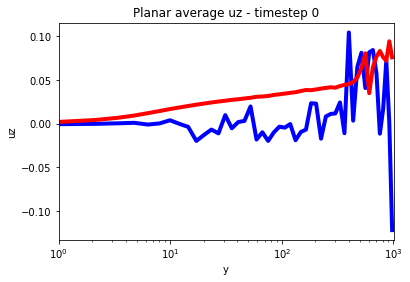

In [13]:
cdpFiles=[
"/workspace/jmelvin/Research/dataFiles/cdp-SST-debug/HYB-SST1000.010000.plt",
"/workspace/jmelvin/Research/dataFiles/cdp-SST-debug/HYB-SST1000.025000.plt"
]
naluFiles=[
"/workspace/jmelvin/Research/dataFiles/cdp-SST-debug/TAMS-SST-Re1000-newRANSsoln.e",
"/workspace/jmelvin/Research/dataFiles/cdp-SST-debug/TAMS-SST-Re1000-newRANSsoln.e"
]
plotDiff(cdpFiles, naluFiles, 36, [0,100], "uz", True,  9.99488e-4)

step 030000
539.9999999990855


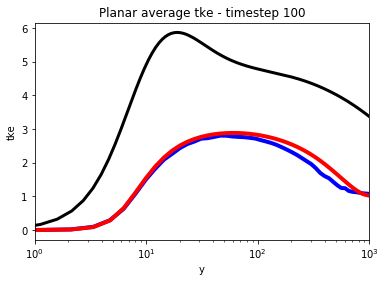

In [9]:
stepNum = 100
dnsfn = '/workspace/jmelvin/Research/channelFlow/channelFlow/dns_data/Re1000.txt'
#dnsfn = '/workspace/jmelvin/Research/channelFlow/channelFlow/dns_data/tke-Re1000.txt'
cdpfn = [
    '/workspace/jmelvin/Research/dataFiles/cdp-SST-debug/HYB-SST1000.' + str(10000+200*stepNum).zfill(6) + '.plt'
]
nalubn=[
    '/workspace/jmelvin/Research/dataFiles/cdp-SST-debug/TAMS-SST-Re1000-newRANSsoln.e'
]
naluNP = [36]
visco = 0.000999488 # 0.000192831 
DSplotCDPvsNalu(cdpfn,nalubn,naluNP,["tke"],True,visco,stepNum,False,False,dnsfn,False,100,1000,-0.1,1.4)

In [4]:
firstHYB = NaluProc("/workspace/jmelvin/Research/dataFiles/sst-debug/TAMS-SST-Re1000-debug.e",36,0)
secondHYB = NaluProc("/workspace/jmelvin/Research/dataFiles/sst-debug/TAMS-SST-Re1000-debug.e",36,2)
firstRANS = NaluProc("/workspace/jmelvin/Research/dataFiles/sst-debug/channelflow-test.e",1,-2)
secondRANS = NaluProc("/workspace/jmelvin/Research/dataFiles/sst-debug/channelflow-test.e",1,-1)

/workspace/jmelvin/Research/dataFiles/sst-debug/TAMS-SST-Re1000-debug.e 36 0
299.99999999987216
/workspace/jmelvin/Research/dataFiles/sst-debug/TAMS-SST-Re1000-debug.e 36 2
300.0039999998722
/workspace/jmelvin/Research/dataFiles/sst-debug/channelflow-test.e 1 -2
479.99999999970845
/workspace/jmelvin/Research/dataFiles/sst-debug/channelflow-test.e 1 -1
499.99999999969026


In [5]:
diffux = firstRANS.ux - secondRANS.ux
diffuy = firstRANS.uy - secondRANS.uy
diffuz = firstRANS.uz - secondRANS.uz
print diffux.min(), diffuy.min(), diffuz.min()
print diffux.max(), diffuy.max(), diffuz.max()

diffux = firstHYB.ux - secondHYB.ux
diffuy = firstHYB.uy - secondHYB.uy
diffuz = firstHYB.uz - secondHYB.uz
print diffux.min(), diffuy.min(), diffuz.min()
print diffux.max(), diffuy.max(), diffuz.max()

diffux = secondHYB.ux - secondRANS.ux
diffuy = secondHYB.uy - secondRANS.uy
diffuz = secondHYB.uz - secondRANS.uz
print diffux.min(), diffuy.min(), diffuz.min()
print diffux.max(), diffuy.max(), diffuz.max()

0.0 0.0 0.0
1.000017846308765e-10 0.0 0.0
-0.00014093089999978048 -1.5739e-05 -2.43949e-05
1.1983600000320394e-05 1.5809499999999998e-05 2.43942e-05
-4.6843651299 -1.58132e-05 -2.4394e-05
22.213040379 1.57421e-05 2.44019e-05


In [8]:
diffx = (firstRANS.sdr - secondRANS.sdr)/secondRANS.sdr
print diffx.max(), diffx.idxmax()
print firstRANS.iloc[8124]
print secondRANS.iloc[8124]
print diffx.min()

1.3776012300772112e-11 8124
sdr    7.258995e+00
tke    1.024834e+00
ux     2.221453e+01
uy    -4.000000e-09
uz     1.700000e-09
x      4.065590e+00
y      1.027753e+00
z      3.926991e-01
Name: 8124, dtype: float64
sdr    7.258995e+00
tke    1.024834e+00
ux     2.221453e+01
uy    -4.000000e-09
uz     1.700000e-09
x      4.065590e+00
y      1.027753e+00
z      3.926991e-01
Name: 8124, dtype: float64
0.0


In [144]:
diffx

0      0.000000
1      0.000000
2      0.000000
3      0.000000
4      0.000000
5      0.000000
6      0.000000
7      0.000000
8      0.000000
9      0.000000
10     0.000000
11     0.000000
12     0.000000
13     0.000000
14     0.000014
15     0.000014
16     0.000014
17     0.000014
18     0.000014
19     0.000014
20     0.000014
21     0.000014
22     0.000014
23     0.000014
24     0.000014
25     0.000014
26     0.000014
27     0.000014
28     0.000048
29     0.000048
         ...   
714    0.000014
715    0.000014
716    0.000014
717    0.000014
718    0.000014
719    0.000014
720    0.000014
721    0.000014
722    0.000014
723    0.000014
724    0.000014
725    0.000014
726    0.000014
727    0.000014
728    0.000014
729    0.000000
730    0.000000
731    0.000000
732    0.000000
733    0.000000
734    0.000000
735    0.000000
736    0.000000
737    0.000000
738    0.000000
739    0.000000
740    0.000000
741    0.000000
742    0.000000
743    0.000000
Name: sdr, Length: 26211

In [133]:
secondRANS.sdr

0      799590.400000
1      799590.400000
2      799590.400000
3      799590.400000
4      799590.400000
5      799590.400000
6      799590.400000
7      799590.400000
8      799590.400000
9      799590.400000
10     799590.400000
11     799590.400000
12     799590.400000
13     799590.400000
14      90481.051533
15      90481.051531
16      90481.051530
17      90481.051533
18      90481.051531
19      90481.051530
20      90481.051533
21      90481.051531
22      90481.051529
23      90481.051532
24      90481.051530
25      90481.051529
26      90481.051533
27      90481.051530
28      23589.125299
29      23589.125294
           ...      
714     90481.051531
715     90481.051532
716     90481.051531
717     90481.051529
718     90481.051531
719     90481.051530
720     90481.051530
721     90481.051530
722     90481.051531
723     90481.051530
724     90481.051530
725     90481.051529
726     90481.051529
727     90481.051529
728     90481.051529
729    799590.400000
730    799590

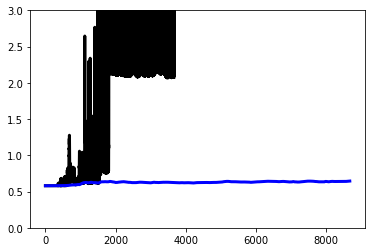

In [10]:
import pandas as pd 
import matplotlib.pyplot as plt
oldCourant = pd.read_csv("/Users/jmelvin/Desktop/WorkFromHome/dump.txt", delim_whitespace=True)
newCourant = pd.read_csv("/Users/jmelvin/Desktop/WorkFromHome/dumpNew.txt", delim_whitespace=True)
fig, ax = plt.subplots()
ax.plot(oldCourant["0.580235"],'k',linewidth=3)
ax.plot(newCourant["0.580235"],"b",linewidth=3)
ax.set_ylim([0, 3.])
plt.show()